In [1]:
import numpy as np
import pandas as pd
import requests
import time
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Put your Alpha Vantage API Key here:
APIKEY = '7CFUAQQUK36OOGM8'

In [2]:
columns_to_drop = ['open', 'high', 'low']

globalpar = {
    'test1' : {
        'data' : {
            'ticker' : 'AAPL',
            'interval' : '1min',
            'minutes' : 1,
            'sma_range' : 30, ## A half hour
            
        },
        'structure' : {
            'training_size' : 0.8,
            'test_size' : 0.2,
            'total_size' : 4800,
            'sequence_size' : 10,
            'batch_size' : 64,
            'input_size' : 4,
        },
        'training' : {
            'sequence_size' : 10,
            'batch_size' : 64,
            'model_input_size' : 4,
            'model_lstm_layers' : 2,
            'model_lstm_size' : 128,
            'model_dropout' : 0.3,
            'model_output' : 1,
            'epochs' : 200,
            'optimizer' : 'Adam', 
            'lrs': [0.001,0.0001, 0.00001],
            'lr_change': True,
            'epochs_change' : 80,
            'weigth_decay' : 0.
        },
    },
    'test5' : {
        'data' : {
            'ticker' : 'AAPL',
            'interval' : '5min',
            'minutes' : 5,
            'sma_range' : 24, ## Three hours
            
        },
        'structure' : {
            'training_size' : 0.8,
            'test_size' : 0.2,
            'total_size' : 28800,
            'sequence_size' : 6,
            'batch_size' : 128,
            'input_size' : 4,
        },
        'training' : {
            'sequence_size' : 6,
            'batch_size' : 128,
            'model_input_size' : 4,
            'model_lstm_layers' : 1,
            'model_lstm_size' : 512,
            'model_dropout' : 0.3,
            'model_output' : 1,
            'epochs' : 200,
            'optimizer' : 'Adam',
            'lrs': [0.005,0.001],
            'lr_change': True,
            'epochs_change' : 150,
            'weigth_decay' : 0.
        },
    },
    'test30' : {
        'data' : {
            'ticker' : 'AAPL',
            'interval' : '30min',
            'minutes' : 30,
            'sma_range' : 32, ## A day
            
        },
        'structure' : {
            'training_size' : 0.8,
            'test_size' : 0.2,
            'total_size' : 4800,
            'sequence_size' : 32,
            'batch_size' : 64,
            'input_size' : 4,
        },
        'training' : {
            'sequence_size' : 32,
            'batch_size' : 64,
            'model_input_size' : 4,
            'model_lstm_layers' : 3,
            'model_lstm_size' : 128,
            'model_dropout' : 0.3,
            'model_output' : 1,
            'epochs' : 300,
            'optimizer' : 'Adam',
            'lrs': [0.001,0.0005],
            'lr_change': True,
            'epochs_change' : 220,
            'weigth_decay' : 0.
        },
    },
    'test60' : {
        'data' : {
            'ticker' : 'AAPL',
            'interval' : '60min',
            'minutes' : 60,
            'sma_range' : 64, ## four days
            
        },
        'structure' : {
            'training_size' : 0.8,
            'test_size' : 0.2,
            'total_size' : 7200,
            'sequence_size' : 64,
            'batch_size' : 128,
            'input_size' : 4,
        },
        'training' : {
            'sequence_size' : 64,
            'batch_size' : 128,
            'model_input_size' : 4,
            'model_lstm_layers' : 3,
            'model_lstm_size' : 128,
            'model_dropout' : 0.3,
            'model_output' : 1,
            'epochs' : 300,
            'optimizer' : 'Adam',
            'lrs': [0.005,0.0005,0.00005],
            'lr_change': True,
            'epochs_change' : 120,
            'weigth_decay' : 0.
        }
    }
    
}

In [3]:
######## Lets'collect and clean the data from Apple in the last two years daily
######## from Alpha Advantage API.

def get_Intraday24m(param, period, adjusted='True', apikey=APIKEY):
    '''
    This function returns historical intraday time series for the trailing 2
    years, covering over 2 million data points per ticker. The intraday data is
    computed directly from the Securities Information Processor (SIP) market-
    aggregated data feed. You can query both raw (as-traded) and split/dividend-
    adjusted intraday data from this endpoint. Common use cases for this API
    include data visualization, trading simulation/backtesting, and machine
    learning and deep learning applications with a longer horizon.

    Function Parameters:

    * Required: param: a Dictionary with at least the next itmes:
    
            ** ticker: The name of the equity of your choice. Example: 'IBM'
            ** interval: '1min', '5min', '15min', '30min', '60min'

    * Required: period: 'year1month1',...,'year1month12',
                       'year2month1',...,'year2month12'

    * Optional: adjusted: True or False

    * Required: apikey

    Returns:
        A Dataframe with the next columns: time, open, high, low, close, volume
        The filepath option for saving purpose
    '''
    function = 'TIME_SERIES_INTRADAY_EXTENDED'
    url = 'https://www.alphavantage.co/query?function='+function+              \
                                            '&symbol='+param['ticker']+         \
                                            '&interval='+param['interval']+     \
                                            '&slice='+period+                  \
                                            '&adjusted='+adjusted+             \
                                            '&apikey='+apikey

    return pd.read_csv(url, index_col='time').dropna()

In [4]:
def collecting_all_data(param, apikey=APIKEY):
    
    period = 'year1month1'
    raw_data = get_Intraday24m(param, period, apikey = APIKEY)

    for year in ['1','2']:
        for month in ['2','3','4','5','6','7','8','9','10','11','12']:
            period = 'year' + year + 'month' + month
            raw_data = pd.concat([raw_data, get_Intraday24m(param, period)])
            time.sleep(13)
    return raw_data.sort_values(by='time')
        

In [5]:
#########1#########2#########3#########4#########5#########6#########7#########8

In [216]:
apple_raw_1min = collecting_all_data(globalpar['test1']['data'])
apple_raw_1min

,open,high,low,close,volume
time,,,,,
2020-03-25 04:01:00,62.887084,62.887084,62.665130,62.887084,17712
2020-03-25 04:02:00,62.640468,62.763776,62.393852,62.492498,20484
2020-03-25 04:03:00,62.393852,62.640468,62.393852,62.591145,10592
2020-03-25 04:04:00,62.591145,62.615806,62.393852,62.418514,10292
2020-03-25 04:05:00,62.420980,62.420980,62.393852,62.420980,7556
...,...,...,...,...,...
2022-03-14 19:56:00,150.950000,150.950000,150.930000,150.930000,2613
2022-03-14 19:57:00,150.950000,151.000000,150.930000,150.940000,7543
2022-03-14 19:58:00,150.930000,150.970000,150.820000,150.970000,3703


In [217]:
apple_raw_1min.info()

<class 'pandas.core.frame.DataFrame'>
Index: 385906 entries, 2020-03-25 04:01:00 to 2022-03-14 20:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    385906 non-null  float64
 1   high    385906 non-null  float64
 2   low     385906 non-null  float64
 3   close   385906 non-null  float64
 4   volume  385906 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 17.7+ MB


<AxesSubplot:label='6213a5f4-a62e-4282-bf65-2cf657a73056'>

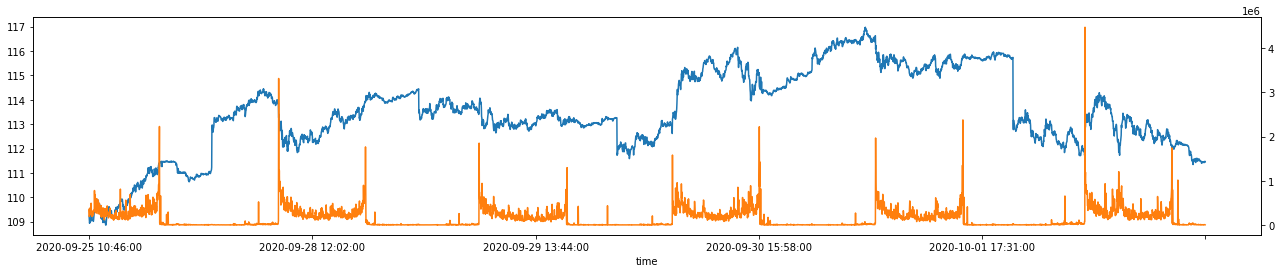

In [14]:
apple_raw_1min[100000:105000]['close'].plot(figsize=(22,4))
apple_raw_1min[100000:105000]['volume'].plot(figsize=(22,4), secondary_y=True)

In [47]:
apple_raw_5min = collecting_all_data(globalpar['test5']['data'])
apple_raw_5min

,open,high,low,close,volume
time,,,,,
2020-03-24 04:05:00,57.466464,57.954764,57.214916,57.942433,67780
2020-03-24 04:10:00,57.905441,58.041079,57.759937,57.927636,31936
2020-03-24 04:15:00,57.757471,57.912839,57.461532,57.656358,28208
2020-03-24 04:20:00,57.602103,57.732809,57.602103,57.646494,22072
2020-03-24 04:25:00,57.634163,57.634163,57.279036,57.279036,16808
...,...,...,...,...,...
2022-03-11 19:40:00,154.460000,154.500000,154.450000,154.500000,3642
2022-03-11 19:45:00,154.460000,154.500000,154.450000,154.480000,16214
2022-03-11 19:50:00,154.490000,154.500000,154.460000,154.480000,4864


In [48]:
apple_raw_30min = collecting_all_data(globalpar['test30']['data']

,open,high,low,close,volume
time,,,,,
2020-03-24 04:30:00,57.466464,58.041079,57.214916,57.288900,182736
2020-03-24 05:00:00,57.276570,57.708148,57.140931,57.592238,46128
2020-03-24 05:30:00,57.703215,57.806794,57.683486,57.683486,49560
2020-03-24 06:00:00,57.708148,58.171786,57.658825,58.171786,60708
2020-03-24 06:30:00,58.201380,58.667484,58.201380,58.420868,108820
...,...,...,...,...,...
2022-03-11 18:00:00,154.590000,154.720000,154.570000,154.620000,23416
2022-03-11 18:30:00,154.670000,154.680000,154.350000,154.380000,25472
2022-03-11 19:00:00,154.350000,154.490000,154.330000,154.490000,30387


In [50]:
apple_raw_5min.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88268 entries, 2020-03-24 04:05:00 to 2022-03-11 20:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    88268 non-null  float64
 1   high    88268 non-null  float64
 2   low     88268 non-null  float64
 3   close   88268 non-null  float64
 4   volume  88268 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 4.0+ MB


<AxesSubplot:xlabel='time'>

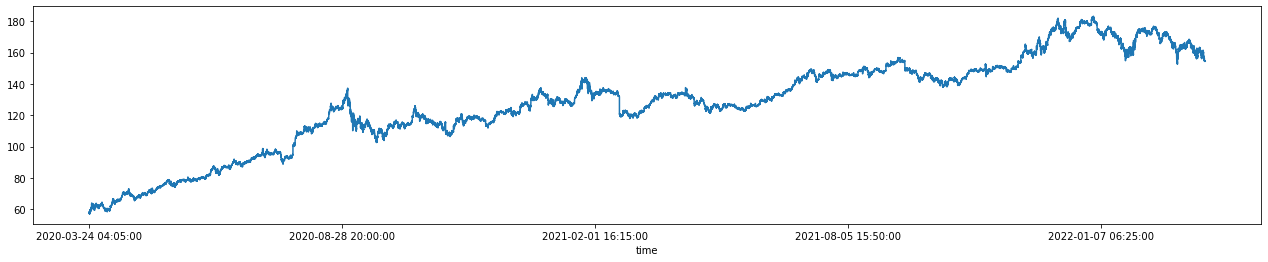

In [68]:
apple_raw_5min['close'].plot(figsize=(22,4))

In [51]:
apple_raw_30min.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15159 entries, 2020-03-24 04:30:00 to 2022-03-11 20:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    15159 non-null  float64
 1   high    15159 non-null  float64
 2   low     15159 non-null  float64
 3   close   15159 non-null  float64
 4   volume  15159 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 710.6+ KB


<AxesSubplot:xlabel='time'>

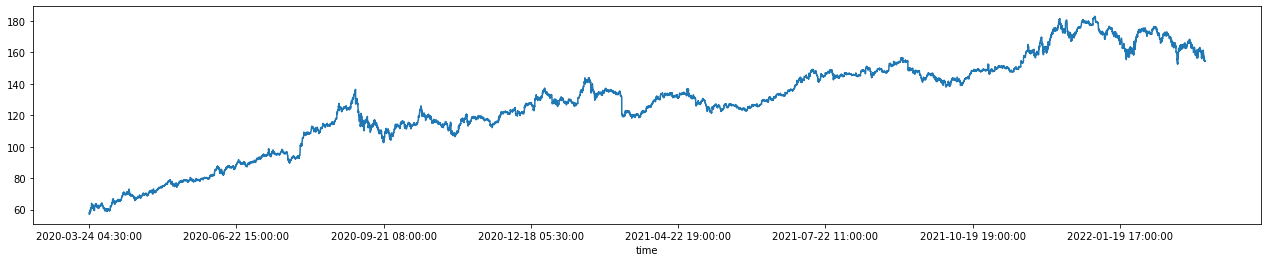

In [69]:
apple_raw_30min['close'].plot(figsize=(22,4))

In [122]:
apple_raw_60min = collecting_all_data(globalpar['test60']['data'])

In [123]:
# Lets save them all for future implementations
def saving_ticker_data(dataset, param):
    dit = os.getcwd()
    filepath = dit + '/' + param['ticker'] + '_all_' + param['interval']
    dataset.to_csv(filepath)
    
saving_ticker_data(apple_raw_30min, globalpar['test30']['data'])
saving_ticker_data(apple_raw_5min, globalpar['test5']['data'])
saving_ticker_data(apple_raw_1min, globalpar['test1']['data'])
saving_ticker_data(apple_raw_60min, globalpar['test60']['data'])

In [5]:
############### SECOND PART ##########################
######################################################

# Lets save them all for future implementations
def loading_ticker_data(param):
    dit = os.getcwd()
    filepath = dit + '/' + param['ticker'] + '_all_' + param['interval']
    
    return pd.read_csv(filepath, index_col = 'time')
    
apple_raw_30min = loading_ticker_data(globalpar['test30']['data'])
apple_raw_5min = loading_ticker_data(globalpar['test5']['data'])
apple_raw_1min = loading_ticker_data(globalpar['test1']['data'])
apple_raw_60min = loading_ticker_data(globalpar['test60']['data'])


In [7]:
apple_raw_1min

,open,high,low,close,volume
time,,,,,
2020-03-24 04:01:00,57.466464,57.954764,57.466464,57.831456,19176
2020-03-24 04:02:00,57.708148,57.708148,57.214916,57.584840,12504
2020-03-24 04:03:00,57.681020,57.836388,57.291367,57.831456,26092
2020-03-24 04:04:00,57.609501,57.609501,57.609501,57.609501,1552
2020-03-24 04:05:00,57.757471,57.942433,57.757471,57.942433,8456
...,...,...,...,...,...
2022-03-11 19:56:00,154.460000,154.460000,154.450000,154.450000,408
2022-03-11 19:57:00,154.450000,154.480000,154.450000,154.450000,1246
2022-03-11 19:58:00,154.470000,154.480000,154.450000,154.480000,4393


In [8]:
#########1#########2#########3#########4#########5#########6#########7#########8

In [499]:
def filling_blank_periods_and_adding_market(data, param):
    
    cut = {
        '1min' : -59,
        '5min' : -11,
        '30min' : -1,
        '60min' : None
    }
    
    dates = pd.DataFrame(set(data.index.map(lambda x: x.split(' ')[0])), 
                         columns=['date']).sort_values(by='date')
    timing = [str(hour).zfill(2) + ':' + str(minutes).zfill(2) \
                               for hour in range(4,21,1) \
                               for minutes in range(0, 60, 
                                                    param['minutes'])]\
                                                    [1:cut[param['interval']]]
    market_time = [-1 if time<'09:30' else 1 if time>'16:00' \
                                      else 0 for time in timing]
    data_market = pd.DataFrame(market_time * len(dates), 
                               index=[date + ' ' + time + ':00' \
                                      for date in dates.date    \
                                      for time in timing], columns=['market'])
    full_data = data_market.merge(data.copy(), how = 'left', left_index = True,
                                                  right_index = True)
    return full_data
    
    
def filling_nas(data):
    
    for col in data.columns:
        if col == 'volume':
            data[col] = data[col].fillna(0)
        elif col != 'market':
            data[col] = data[col].fillna(method='ffill')
    return data

In [7]:
apple_raw_1min = filling_blank_periods_and_adding_market(apple_raw_1min, globalpar['test1']['data'])

In [12]:
apple_raw_1min.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456000 entries, 2020-03-24 04:01:00 to 2022-03-11 20:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   market  456000 non-null  int64  
 1   open    385916 non-null  float64
 2   high    385916 non-null  float64
 3   low     385916 non-null  float64
 4   close   385916 non-null  float64
 5   volume  385916 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 44.4+ MB


In [13]:
apple_raw_1min = filling_nas(apple_raw_1min)
apple_pre_1min = apple_raw_1min.drop(columns=columns_to_drop)
apple_pre_1min

,market,close,volume
2020-03-24 04:01:00,-1,57.831456,19176.0
2020-03-24 04:02:00,-1,57.584840,12504.0
2020-03-24 04:03:00,-1,57.831456,26092.0
2020-03-24 04:04:00,-1,57.609501,1552.0
2020-03-24 04:05:00,-1,57.942433,8456.0
...,...,...,...
2022-03-11 19:56:00,-1,154.450000,408.0
2022-03-11 19:57:00,-1,154.450000,1246.0
2022-03-11 19:58:00,-1,154.480000,4393.0
2022-03-11 19:59:00,-1,154.450000,2525.0


In [14]:
apple_pre_1min.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456000 entries, 2020-03-24 04:01:00 to 2022-03-11 20:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   market  456000 non-null  int64  
 1   close   456000 non-null  float64
 2   volume  456000 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 33.9+ MB


In [8]:
def sma_and_momentum(data, param):
    
    momentum = param['sma_range']
    data['sma'] = data.close.rolling(momentum).mean()
    data['momentum'] = 10 * np.log(data['sma'] / data['sma'].shift(momentum))
    data = data.iloc[momentum * 2:]
    
    return data

In [466]:
apple_mom_1min = sma_and_momentum(apple_pre_Xmin, globalpar['test1']['data'])
apple_mom_1min

,market,close,volume,sma,momentum
2020-03-24 05:01:00,-1,57.806794,8024.0,57.538229,-0.016160
2020-03-24 05:02:00,-1,57.759937,4000.0,57.554013,-0.011691
2020-03-24 05:03:00,-1,57.708148,6088.0,57.568070,-0.006096
2020-03-24 05:04:00,-1,57.708148,808.0,57.586977,-0.000100
2020-03-24 05:05:00,-1,57.708148,0.0,57.601034,0.006139
...,...,...,...,...,...
2022-03-11 19:56:00,-1,154.450000,408.0,154.491340,-0.001359
2022-03-11 19:57:00,-1,154.450000,1246.0,154.489340,-0.001531
2022-03-11 19:58:00,-1,154.480000,4393.0,154.487007,-0.001877
2022-03-11 19:59:00,-1,154.450000,2525.0,154.483673,-0.002286


<AxesSubplot:>

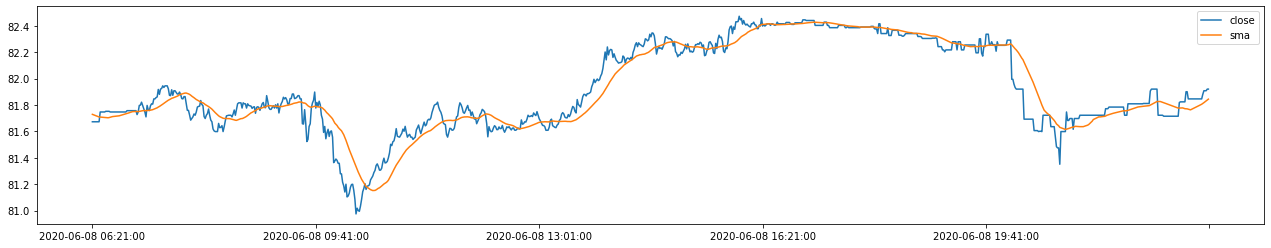

In [467]:
apple_mom_1min[['close','sma']][50000:51000].plot(figsize=(22,4))

<AxesSubplot:>

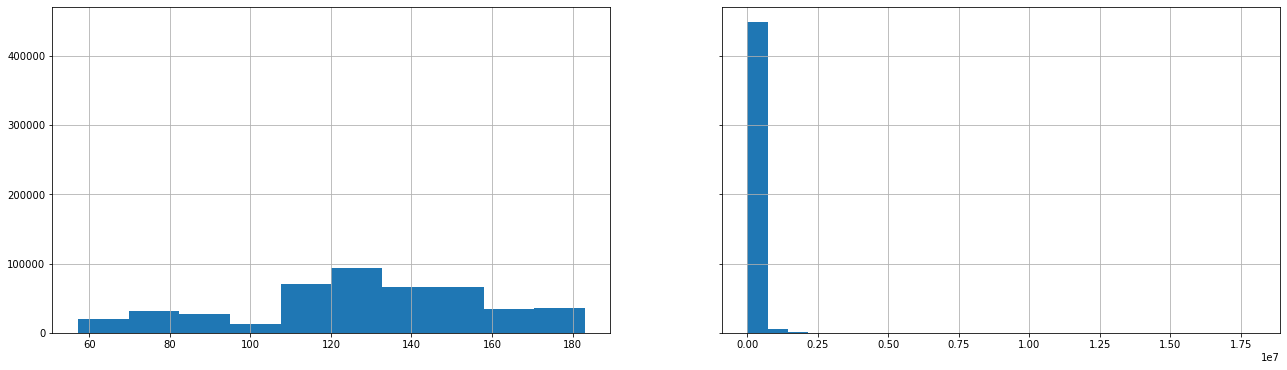

In [18]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(22, 6))
apple_mom_1min.close.hist(ax=ax[0])
apple_mom_1min.volume.hist(ax=ax[1], bins=25)

In [9]:
def final_set(data):
    
    dataset = data.copy()
    
    scaler_vol = StandardScaler()
    scaler_close = MinMaxScaler()

    dataset['volume'] = scaler_vol.fit_transform(np.array(dataset['volume']).reshape(-1,1))
    dataset['close'] = scaler_close.fit_transform(np.array(dataset['close']).reshape(-1,1))

    # Lets add the resulting column or the next minute price
    dataset['next'] = dataset['close'].shift(-1)
    # Guarantee we have all in float32 data type
    for col in dataset.columns:
        dataset[col] = dataset[col].astype('float32')

    dataset.drop(columns='sma', inplace=True)
    
    return dataset[:-1], scaler_vol, scaler_close

In [19]:
apple_set_1min, volscaler_1, closescaler_1 = final_set(apple_mom_1min)
apple_set_1min

,market,close,volume,momentum,next
2020-03-24 05:01:00,-0.1,0.005480,-0.437288,-0.016160,0.005108
2020-03-24 05:02:00,-0.1,0.005108,-0.454540,-0.011691,0.004697
2020-03-24 05:03:00,-0.1,0.004697,-0.445588,-0.006096,0.004697
2020-03-24 05:04:00,-0.1,0.004697,-0.468226,-0.000100,0.004697
2020-03-24 05:05:00,-0.1,0.004697,-0.471690,0.006139,0.004697
...,...,...,...,...,...
2022-03-11 19:55:00,0.1,0.772825,-0.471690,-0.001229,0.772428
2022-03-11 19:56:00,0.1,0.772428,-0.469941,-0.001359,0.772428
2022-03-11 19:57:00,0.1,0.772428,-0.466348,-0.001531,0.772667
2022-03-11 19:58:00,0.1,0.772667,-0.452855,-0.001877,0.772428


In [10]:
# defining final arrays
def final_array(data, param):
        
    dataset = data[-param['total_size']-param['sequence_size']:].values
    print('dataset len:', len(dataset))
    total_batches = (param['total_size'] // param['batch_size'])
    print('total_batches:', total_batches)
    total_test_batches = int(total_batches * param['test_size']) 
    print('total_test_batches:', total_test_batches)
    total_train_batches = total_batches - total_test_batches
    print('total_train_batches:', total_train_batches)
    print(-total_batches * param['batch_size'] - param['sequence_size'] + 1,
          -total_test_batches * param['batch_size'],
          (-total_test_batches * param['batch_size'] - param['sequence_size'] + 1))
    train_values = dataset[-total_batches * param['batch_size'] - param['sequence_size'] + 1: -total_test_batches * param['batch_size']]
    
    test_values = dataset[(-total_test_batches * param['batch_size'] - param['sequence_size'] + 1):]
    
    print('train values shape: {}, test values shape: {}'.format(train_values.shape, test_values.shape))

    train_X, train_y = train_values[:,:-1], train_values[param['sequence_size']-1:,-1]
    print('train X shape: {}, train y shape: {}'.format(train_X.shape, train_y.shape))
    train_batches = len(train_X) - param['sequence_size'] + 1
    print('train_batches:',train_batches)
    train_X = np.lib.stride_tricks.as_strided(train_X.flatten(), 
                                              shape=(train_batches, 
                                                     param['sequence_size'], 
                                                     param['input_size']), 
                                              strides=(param['input_size']*4,
                                                       param['input_size']*4,
                                                       4))
   # train_y = train_y[:]
    print('final train X shape: {}, train y shape: {}'.format(train_X.shape, train_y.shape))

    test_X, test_y = test_values[:,:-1], test_values[param['sequence_size']-1:,-1]
    print('test X shape: {}, test y shape: {}'.format(test_X.shape, test_y.shape))
    test_batches = len(test_X) - param['sequence_size'] + 1
    print('test_batches:',test_batches)
    test_X = np.lib.stride_tricks.as_strided(test_X.flatten(), 
                                             shape=(test_batches, 
                                                    param['sequence_size'], 
                                                    param['input_size']), 
                                             strides=(param['input_size']*4,
                                                      param['input_size']*4,
                                                      4))
    #test_y = test_y[param['sequence_size']-1:]
    print('final test X shape: {}, test y shape: {}'.format(test_X.shape, test_y.shape))
    
    # To tensors:
    train_X = torch.Tensor(train_X)
    test_X = torch.Tensor(test_X)
    train_y = torch.Tensor(train_y)
    test_y = torch.Tensor(test_y)

    return train_X, train_y, test_X, test_y


In [21]:
train_X, train_y, test_X, test_y = final_array(apple_set_1min, globalpar['test1']['structure'])

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

torch.Size([7650, 30, 4]) torch.Size([7650]) torch.Size([1891, 30, 4]) torch.Size([1891])


In [11]:
class Data_Prep(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [245]:
class Model_LSTM(torch.nn.Module):
    def __init__(self, param):
        super().__init__()
        self.input_size = param['model_input_size']
        self.hidden_size = param['model_lstm_size']
        self.num_layers = param['model_lstm_layers']
        self.output_size = param['model_output']
        self.drop_prob = param['model_dropout']

        self.linear = torch.nn.Linear(param['model_input_size'], 
                                      param['model_lstm_size'])
        self.relu = torch.nn.ReLU() #-- ORIGINAL
        #self.tanh = torch.nn.Tanh()
        
        self.lstm = torch.nn.LSTM(param['model_lstm_size'], 
                                  hidden_size=self.hidden_size, 
                                  num_layers=self.num_layers,
                                  dropout=self.drop_prob, 
                                  batch_first=True,
                                  bias=True)
        self.dropout = torch.nn.Dropout(param['model_dropout'])
        self.linear_end = torch.nn.Linear(self.hidden_size,# * self.num_layers, 
                                          self.output_size)
        
        

    def forward(self, x, hn, cn):
        
        batchsize = x.shape[0]
        
        x = self.linear(x)
        
        x = self.relu(x) #original
        #x = self.tanh(x)
        
        # LSTM layer
        lstm_out, (hn, cn) = self.lstm(x, (hn.detach(), cn.detach()))
        #lstm_out, self.hidden = self.lstm(x, self.hidden)
        #x = hn.permute(1,0,2).reshape(batchsize, -1)
        #self.hidden.detach()
        
        #x = self.dropout(lstm_out)
        
        out = self.linear_end(lstm_out) #(x)
        
        #out = self.tanh(out)
        
        return out[:,-1].reshape(batchsize), (hn, cn)
    
    '''def init_hidden(self):
        for name, pm in self.lstm.named_parameters():
            if 'bias_ih' in name:
                torch.nn.init.constant_(pm, 0.0)
            elif 'weight_ih' in name:
                torch.nn.init.kaiming_normal_(pm)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(pm)'''

In [13]:
def train_model(model, data, criterion, opt, param):
    
    epoch_loss = 0

    model.train()
    
    cn = Variable(torch.zeros(param['model_lstm_layers'] , param['batch_size'], param['model_lstm_size']))

    hn = Variable(torch.zeros(param['model_lstm_layers'] , param['batch_size'], param['model_lstm_size']))
    
    for n, (x, y) in enumerate(data):
        
        opt.zero_grad()

        batchsize = x.shape[0]
        
        out, (hn, cn) = model(x, hn, cn)
        #out = model(x)
        
        loss = criterion(out, y)
        
        '''l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm
        '''
        loss.backward()
        
        opt.step()

        epoch_loss += (loss.detach().item() / batchsize)

    return epoch_loss

def test_model(model, data, criterion, param):
    
    epoch_loss = 0

    model.eval()
    
    cn = Variable(torch.zeros(param['model_lstm_layers'] , param['batch_size'], param['model_lstm_size']))

    hn = Variable(torch.zeros(param['model_lstm_layers'] , param['batch_size'], param['model_lstm_size']))

    for x, y in data:

        batchsize = x.shape[0]
        
        out, (hn, cn) = model(x, hn, cn)
        
        loss = criterion(out, y)

        epoch_loss += (loss.detach().item() / batchsize)

    return epoch_loss

In [14]:
######## Final approach Adam and lr=0.01

def training_model(train_X, train_y, test_X, test_y, param):
    
    train_series = Data_Prep(train_X, train_y)
    test_series  = Data_Prep(test_X, test_y)
    
    train_dataloader = DataLoader(train_series, batch_size=param['batch_size'],
                                  shuffle=True)
    test_dataloader  = DataLoader(test_series, batch_size=param['batch_size'], 
                                 shuffle=True)
    
    model = Model_LSTM(param)

    if param['optimizer'] == 'SGD':
        opt = torch.optim.SGD(model.parameters(), lr=param['lrs'][0], momentum=0.9)
    elif param['optimizer'] == 'Adam':
        opt = torch.optim.Adam(model.parameters(), lr=param['lrs'][0], weight_decay=param['weight_decay'])
    elif param['optimizer'] == 'Adagrad':
        opt = torch.optim.Adagrad(model.parameters(), lr=param['lrs'][0])

    criterion = torch.nn.MSELoss()
    losses_training = []
    losses_testing = []

    print("Optimizer: {}, Leaning rate: {}".format(param['optimizer'], param['lrs'][0]))

    for epoch in range(param['epochs']):
        
        if param['lr_change']:
            change = int(epoch // param['epochs_change'])
            opt.param_groups[0]['lr'] = param['lrs'][change]

        loss_train = train_model(model, train_dataloader, criterion, opt, param)
        
        losses_training.append(loss_train)
        
        loss_test = test_model(model, test_dataloader, criterion, param)
        
        losses_testing.append(loss_test)

        if (epoch+1)%10 == 0:
            print('Epoch[{}/{}] | loss train:{:.8f}, test:{:.8f}, learning rate: {}'
                  .format(epoch+1, param['epochs'], loss_train, loss_test, 
                          opt.param_groups[0]['lr']))

    print('last train: {}, minimo train: {} '.format(losses_training[-1], np.array(losses_training).min()))
    print('last test: {}, minimo test: {}'.format(losses_testing[-1], np.array(losses_testing).min()))
        
    return model, losses_training, losses_testing



In [552]:
learning_rates = [0.05, 0.01, 0.005, 0.001]
optimizers = ['SGD', 'Adagrad', 'Adam']
tests = {}
test = 1

globalpar['test1']['structure']['total_size'] = 4800
train_X, train_y, test_X, test_y = final_array(apple_set_1min, globalpar['test1']['structure'])
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

for optimizer in optimizers:
    for lr in learning_rates:
        
        globalpar['test1']['training']['epochs'] = 100
        globalpar['test1']['training']['optimizer'] = optimizer
        globalpar['test1']['training']['lr'] = lr
        globalpar['test1']['training']['lr_change'] = False
        
        model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y,
                                              globalpar['test1']['training'])
        
        tests['test-'+str(test)] = {'opt' : optimizer,
                                    'lr' : lr,
                                    'training' : loss_train,
                                    'testing' : loss_test,
                                    'min_train' : np.array(loss_train).min(),# the last not the minimum
                                    'min_test' : np.array(loss_test).min()} # the last not the minimum
        test += 1

globalpar['test1']['training']['epochs'] = 200
globalpar['test1']['training']['optimizer'] = 'Adam'
globalpar['test1']['training']['lr'] = 0.005
globalpar['test1']['training']['lr_change'] = True
globalpar['test1']['structure']['total_size'] = 9600

NameError: name 'apple_set_1min' is not defined

<AxesSubplot:title={'center':'ALL TRAINS - THREE OPTIMIZERS'}>

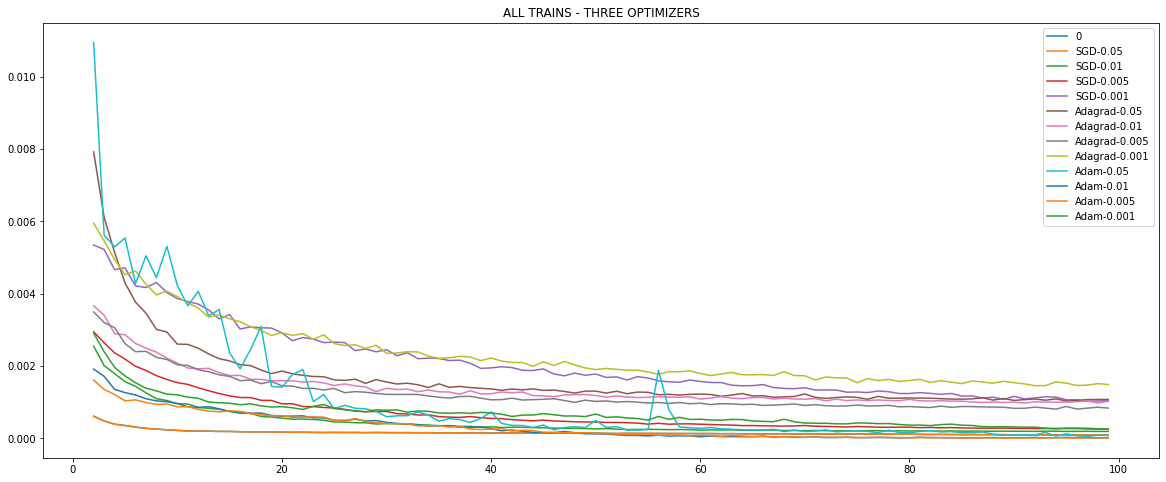

In [268]:
df = pd.DataFrame(tests)
graphs = pd.DataFrame(df.loc['training','test-1'])
for test in tests.keys():
    graphs[test] = pd.DataFrame(df.loc['training',test])
graphs.rename(columns={'test-1':'SGD-0.05', 'test-2':'SGD-0.01', 'test-3':'SGD-0.005', 'test-4':'SGD-0.001',
                       'test-5':'Adagrad-0.05', 'test-6':'Adagrad-0.01', 'test-7':'Adagrad-0.005', 'test-8':'Adagrad-0.001',
                       'test-9':'Adam-0.05', 'test-10':'Adam-0.01', 'test-11':'Adam-0.005', 'test-12':'Adam-0.001'}, inplace=True)
graphs.loc[2:].plot(title='ALL TRAINS - THREE OPTIMIZERS',figsize=(20,8))

<AxesSubplot:title={'center':'ALL TESTS - THREE OPTIMIZERS'}>

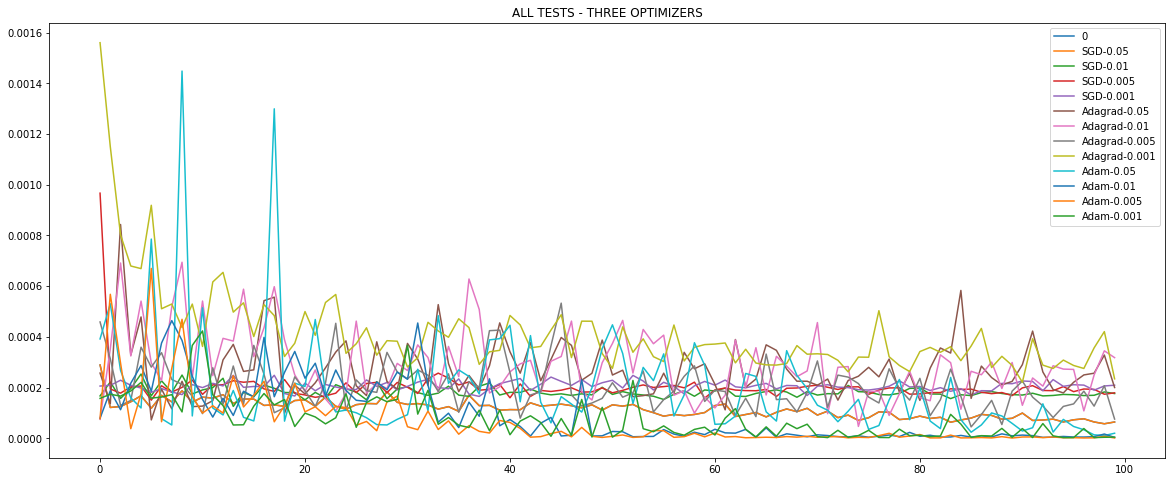

In [269]:
graphs_test = pd.DataFrame(df.loc['testing','test-1'])
for test in tests.keys():
    graphs_test[test] = pd.DataFrame(df.loc['testing',test])
graphs_test.rename(columns={'test-1':'SGD-0.05', 'test-2':'SGD-0.01', 'test-3':'SGD-0.005', 'test-4':'SGD-0.001',
                       'test-5':'Adagrad-0.05', 'test-6':'Adagrad-0.01', 'test-7':'Adagrad-0.005', 'test-8':'Adagrad-0.001',
                       'test-9':'Adam-0.05', 'test-10':'Adam-0.01', 'test-11':'Adam-0.005', 'test-12':'Adam-0.001'}, inplace=True)
graphs_test.loc[:].plot(title='ALL TESTS - THREE OPTIMIZERS', figsize=(20,8))

In [270]:
df.rename(columns={'test-1':'SGD-0.05', 'test-2':'SGD-0.01', 'test-3':'SGD-0.005', 'test-4':'SGD-0.001',
                       'test-5':'Adagrad-0.05', 'test-6':'Adagrad-0.01', 'test-7':'Adagrad-0.005', 'test-8':'Adagrad-0.001',
                       'test-9':'Adam-0.05', 'test-10':'Adam-0.01', 'test-11':'Adam-0.005', 'test-12':'Adam-0.001'}, inplace=True)
df

,SGD-0.05,SGD-0.01,SGD-0.005,SGD-0.001,Adagrad-0.05,Adagrad-0.01,Adagrad-0.005,Adagrad-0.001,Adam-0.05,Adam-0.01,Adam-0.005,Adam-0.001
opt,SGD,SGD,SGD,SGD,Adagrad,Adagrad,Adagrad,Adagrad,Adam,Adam,Adam,Adam
lr,0.05,0.01,0.005,0.001,0.05,0.01,0.005,0.001,0.05,0.01,0.005,0.001
training,"[0.041073829973624125, 0.000915594664761824, 0...","[0.05048000113760388, 0.0028845501236740827, 0...","[0.05663393716873971, 0.003717952409180511, 0....","[0.07327596898411524, 0.006014979933859329, 0....","[2.3188201692177888, 0.011578894996680045, 0.0...","[0.0769094080924868, 0.004330467554288642, 0.0...","[0.027138559464433724, 0.003912594213462024, 0...","[0.03899040016532287, 0.0061893626634093165, 0...","[2.947083270560731, 0.05704693086976048, 0.010...","[0.06461535626851186, 0.0028310580654600497, 0...","[0.022006319878153803, 0.0021919169310636146, ...","[0.031767020728533255, 0.0036508029729970183, ..."
testing,"[0.00028899862284431166, 0.0001215700039210787...","[0.00016704123336239718, 0.0002218715738958313...","[0.0009667659894538311, 0.00019438859313335603...","[0.00020598972155962006, 0.0002088909447983107...","[0.0002572259027666795, 0.00013623159958504923...","[7.465288670443572e-05, 0.0003531704862065713,...","[0.00045879849629792654, 0.0003135920123375919...","[0.0015602949599269778, 0.001149927383396841, ...","[0.0003918209138646489, 0.0005306905929631155,...","[7.915233463791082e-05, 0.00018748303352497585...","[7.760318946696186e-05, 0.0005679260062087061,...","[0.00015744480634956356, 0.0001736168175869222..."
min_train,8.72727e-05,0.000191201,0.000257144,0.00102677,0.00103163,0.00097615,0.000808786,0.0014555,5.27377e-05,8.85507e-06,8.9856e-06,0.000252157
min_test,5.72283e-05,0.000125708,0.000150393,0.000165112,7.24928e-05,4.67461e-05,4.48994e-05,0.000220979,1.07718e-05,3.35809e-06,9.89186e-07,2.56549e-06


<AxesSubplot:>

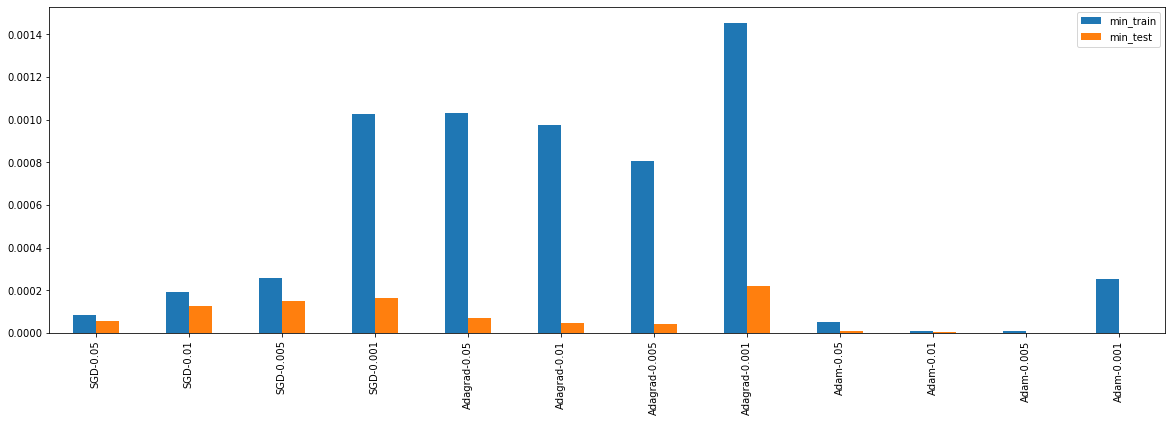

In [272]:
df.T.loc[:,'min_train':'min_test'].plot(figsize=(20,6), kind='bar')

In [26]:
globalpar['test1']['training']

{'sequence_size': 30,
 'batch_size': 64,
 'model_input_size': 4,
 'model_lstm_layers': 3,
 'model_lstm_size': 128,
 'model_dropout': 0.3,
 'model_output': 1,
 'epochs': 200,
 'optimizer': 'Adam',
 'lr': 0.005,
 'lr_change': True,
 'lr_top': 0.001,
 'epochs_top': 150}

In [27]:
model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y,
                                              globalpar['test1']['training'])

Optimizer: Adam, Leaning rate: 0.005
Epoch[10/200] | loss train:0.001612, test:0.000043, learning rate: 0.005
Epoch[20/200] | loss train:0.000825, test:0.000037, learning rate: 0.005
Epoch[30/200] | loss train:0.000386, test:0.000006, learning rate: 0.005
Epoch[40/200] | loss train:0.000108, test:0.000004, learning rate: 0.005
Epoch[50/200] | loss train:0.000020, test:0.000006, learning rate: 0.005
Epoch[60/200] | loss train:0.000023, test:0.000001, learning rate: 0.005
Epoch[70/200] | loss train:0.000016, test:0.000002, learning rate: 0.005
Epoch[80/200] | loss train:0.000018, test:0.000005, learning rate: 0.005
Epoch[90/200] | loss train:0.000018, test:0.000002, learning rate: 0.005
Epoch[100/200] | loss train:0.000011, test:0.000004, learning rate: 0.005
Epoch[110/200] | loss train:0.000018, test:0.000002, learning rate: 0.005
Epoch[120/200] | loss train:0.000013, test:0.000003, learning rate: 0.005
Epoch[130/200] | loss train:0.000009, test:0.000008, learning rate: 0.005
Epoch[140/

<AxesSubplot:title={'center':'Training Loss'}, xlabel='epochs', ylabel='Loss'>

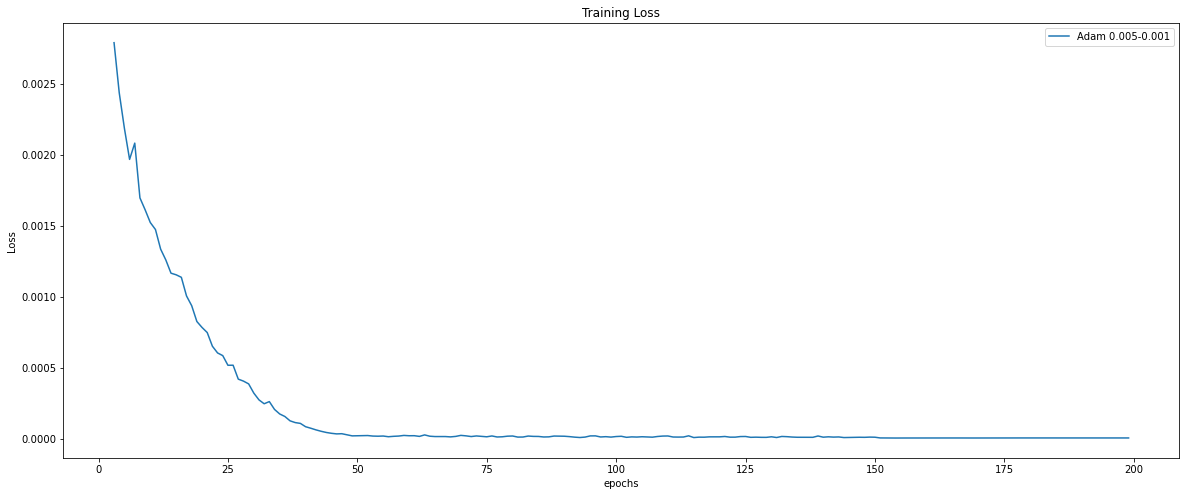

In [28]:
## Adam tests with 200 epochs and volume scaled as normal distribution and close prices as a linear normalization
## And learning rate reduced after 150 epochs.
graphs_Adam_train = pd.DataFrame(loss_train, columns=['Adam 0.005-0.001'])
graphs_Adam_train.loc[3:].plot(figsize=(20,8), title='Training Loss', xlabel='epochs', ylabel='Loss')

<AxesSubplot:title={'center':'Testing Loss'}, xlabel='epochs', ylabel='Loss'>

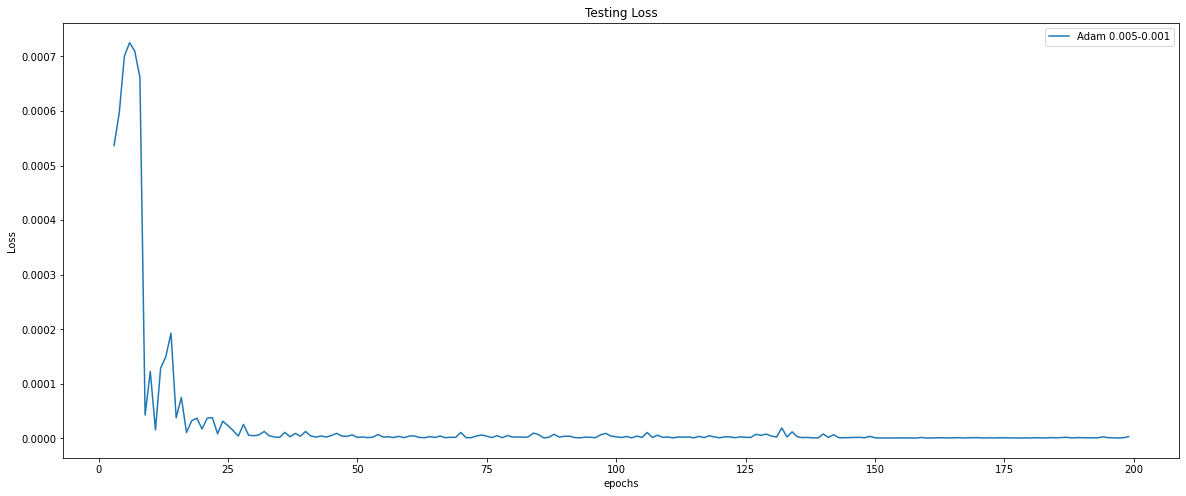

In [29]:
## Adam tests with 200 epochs and volume scaled as normal distribution and close prices as a linear normalization
## And learning rate reduced after 150 epochs.
graphs_Adam_test = pd.DataFrame(loss_test, columns=['Adam 0.005-0.001'])
graphs_Adam_test.loc[3:].plot(figsize=(20,8), title='Testing Loss', xlabel='epochs', ylabel='Loss')

In [30]:
### Saving the model
path = os.getcwd() + '/aapl_predicting_model_1minute.dat'
torch.save(model, path)

In [31]:
### Loading the model
path = os.getcwd() + '/aapl_predicting_model_1minute.dat'
model_1min = torch.load(path)

In [15]:
# Preparing all the data to predict and graph
def data_to_predict(data, param):

    total_rows = (param['total_size'] // param['sequence_size']) * param['sequence_size']
    total_test_rows = int(((total_rows * param['test_size']) // param['sequence_size'] ) * param['sequence_size'])
    total_train_rows = total_rows - total_test_rows

    all_values = data.values[-(total_train_rows+total_test_rows+1):-1]
    batches_to_predict = len(all_values) - param['sequence_size'] + 1
    x, y = all_values[:,:-1], all_values[:,-1]
    x = np.lib.stride_tricks.as_strided(x.flatten(), 
                                        shape=(batches_to_predict, 
                                               param['sequence_size'], param['input_size']), 
                                               strides=(param['input_size'] * 4, param['input_size'] * 4, 4))
    y = y[param['sequence_size']-1:]
    
    return x, y


In [33]:
x_to_predict, y_to_predict = data_to_predict(apple_set_1min, globalpar['test1']['structure'])
print(x_to_predict.shape, y_to_predict.shape)

(9571, 30, 4) (9571,)


In [16]:
def predicted_df(model, x, y, param):
    
    model.eval()
    cn = Variable(torch.zeros(param['model_lstm_layers'] , 1, param['model_lstm_size']))
    hn = Variable(torch.zeros(param['model_lstm_layers'] , 1, param['model_lstm_size']))
    
    
    predicting_series = Data_Prep(x, y)
    # Restarting the dataloader with shuffle in False to have all the data in one sequence
    dataloader_to_predict = DataLoader(predicting_series, batch_size=1, shuffle=False) #param['batch_size']
    # Now iterate for the data and check the predicted values
    results = np.array([[],[]])
    for n, (x, y) in enumerate(dataloader_to_predict):
        y_predicted, (hn, cn) = model(x, hn, cn)
        results = np.concatenate((results, np.array([y.detach().numpy(), y_predicted.detach().numpy()])), axis = 1)

    df = pd.DataFrame(results.T, columns=['close', 'close_predicted'])
    
    return df


In [56]:
predicted_apple = predicted_df(model_1min, x_to_predict, y_to_predict, globalpar['test1']['training'])
predicted_apple.tail(10)

,close,close_predicted
990,0.772667,0.776829
991,0.772349,0.776890
992,0.772825,0.776669
993,0.772825,0.776927
994,0.772825,0.777077
995,0.772825,0.777061
996,0.772428,0.777070
997,0.772428,0.776742
998,0.772667,0.776699
999,0.772428,0.776790


In [17]:
def de_normalize(data, scaler_close):
    
    dataset = data.copy()
    
    dataset['close'] = scaler_close.inverse_transform(np.array(dataset['close']).reshape(-1,1))
    dataset['close_predicted'] = scaler_close.inverse_transform(np.array(dataset['close_predicted']).reshape(-1,1))

    return dataset

In [37]:
predicted_apple_denorm = de_normalize(predicted_apple, closescaler_1)
predicted_apple_denorm

,close,close_predicted
0,161.859997,161.941001
1,162.069999,161.937614
2,161.870001,162.127914
3,161.870001,161.952665
4,161.999998,161.943848
...,...,...
9566,154.500001,155.033762
9567,154.450001,155.034941
9568,154.450001,154.993609
9569,154.479999,154.988141


<AxesSubplot:>

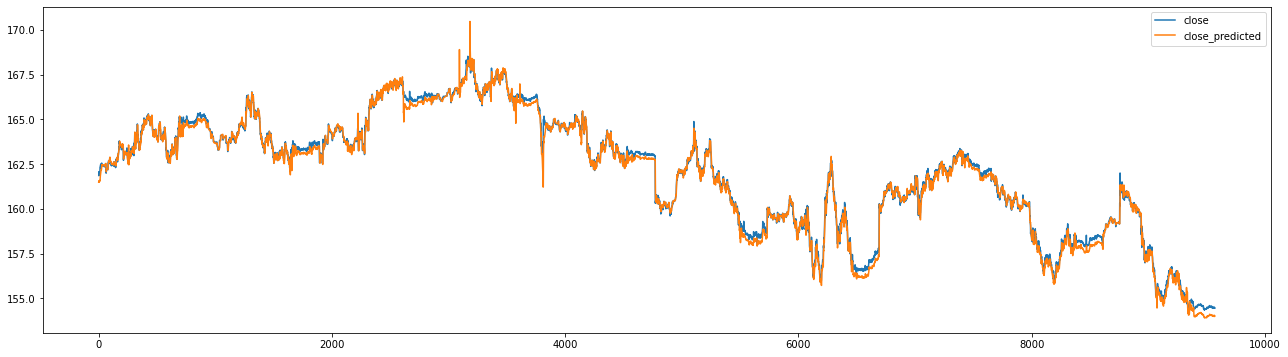

In [361]:
'''DO NOT RUN - THIS WAS THE GRAPH BEFORE ADJUSTING VALUES FOR MARKET
    -1, 0, 1 WERE THE VALUES FOR PRE, MARKET AND POST MARKET
    WE CHANGED THEM TO -.1, 0 , .1'''
predicted_apple_denorm[:].plot(figsize=(22,6))

<AxesSubplot:>

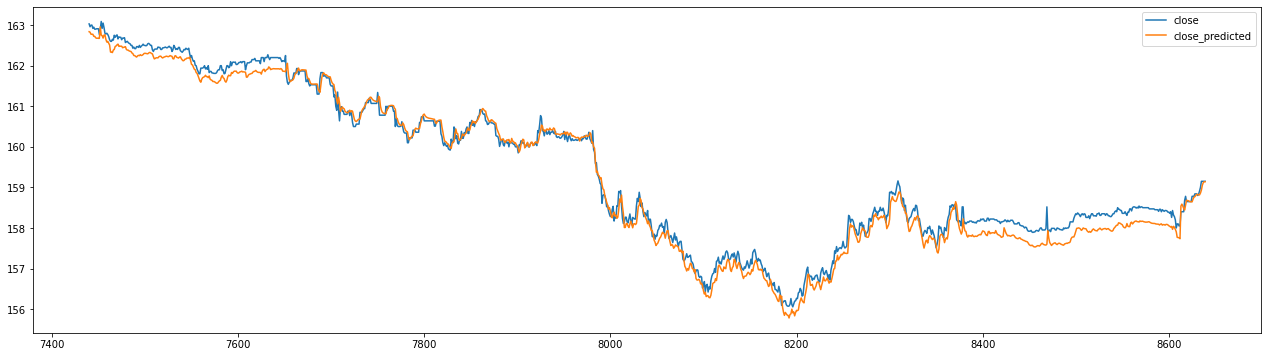

In [362]:
'''DO NOT RUN - THIS WAS THE GRAPH BEFORE ADJUSTING VALUES FOR MARKET
    -1, 0, 1 WERE THE VALUES FOR PRE, MARKET AND POST MARKET
    WE CHANGED THEM TO -.1, 0 , .1'''
predicted_apple_denorm[7440:8640].plot(figsize=(22,6))

<AxesSubplot:>

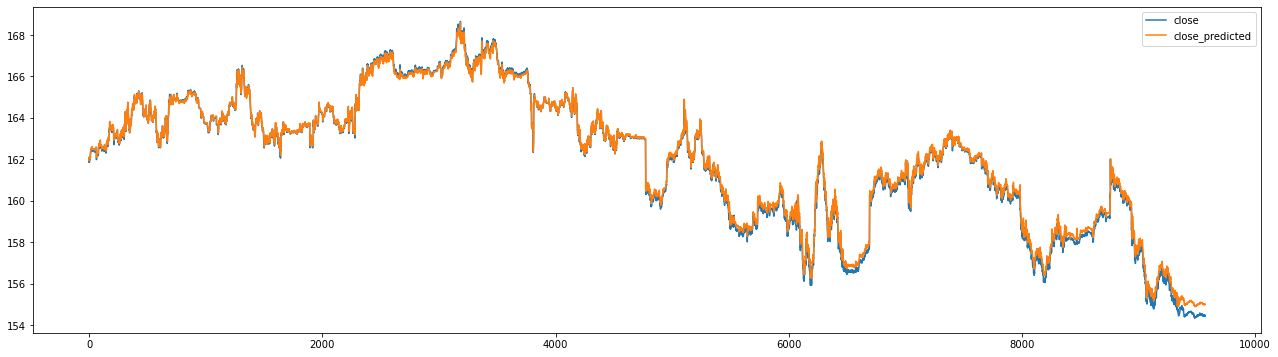

In [38]:
predicted_apple_denorm[:].plot(figsize=(22,6))

<AxesSubplot:>

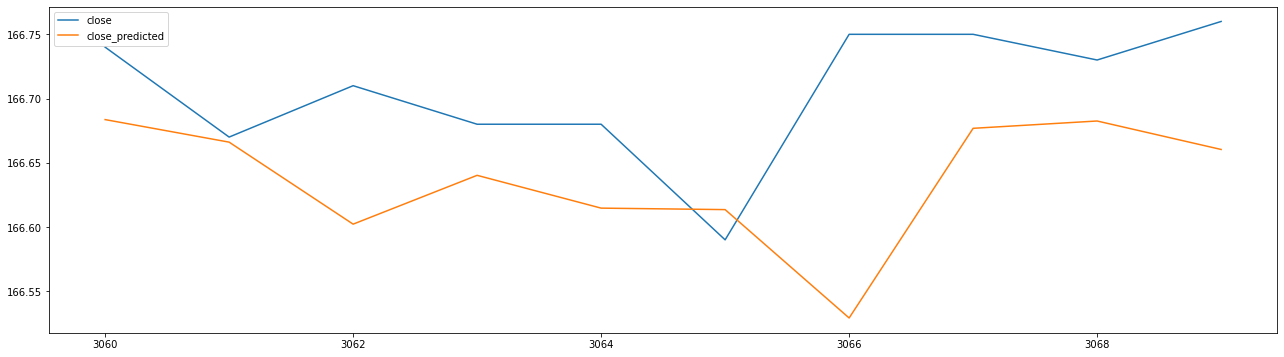

In [54]:
predicted_apple_denorm[3060:3070].plot(figsize=(22,6))

In [58]:
df1 = predicted_apple_denorm.copy()
df1

,close,close_predicted
0,161.859997,161.941001
1,162.069999,161.937614
2,161.870001,162.127914
3,161.870001,161.952665
4,161.999998,161.943848
...,...,...
9566,154.500001,155.033762
9567,154.450001,155.034941
9568,154.450001,154.993609
9569,154.479999,154.988141


<AxesSubplot:>

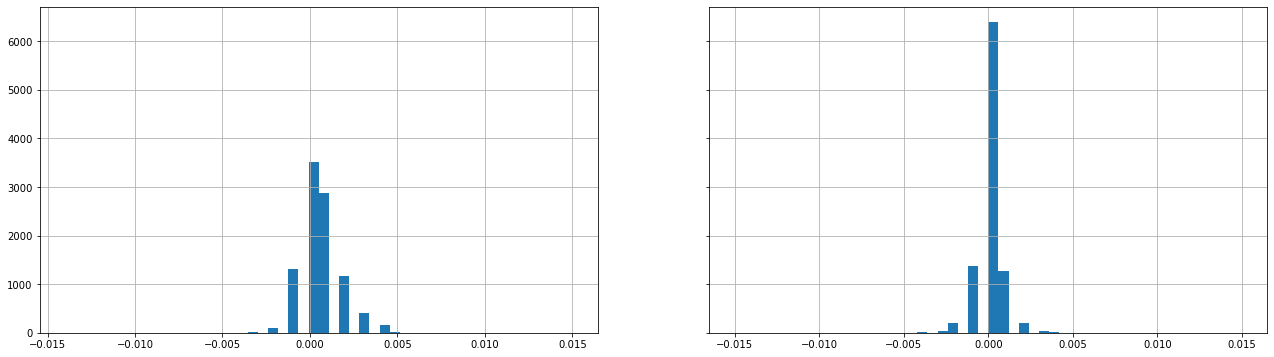

In [81]:
df1['diff'] = round((df1['close_predicted']-df1['close'].shift(2))/df1['close'].shift(1),3)
df1['real_diff'] = round((df1['close']-df1['close'].shift(1))/df1['close'].shift(1),3)

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(22, 6))
df1['diff'].hist(ax=ax[0], bins=50)
df1['real_diff'].hist(ax=ax[1], bins=50)

In [82]:
df1['real_diff'].value_counts()

 0.000    6390
-0.001    1377
 0.001    1277
 0.002     204
-0.002     198
-0.003      45
 0.003      34
-0.004      13
 0.004      12
-0.005       5
 0.005       5
 0.007       3
 0.008       1
 0.015       1
 0.010       1
 0.011       1
-0.007       1
 0.006       1
-0.015       1
Name: real_diff, dtype: int64

In [83]:
df1['diff'].value_counts()

 0.000    3508
 0.001    2872
-0.001    1304
 0.002    1172
 0.003     411
 0.004     151
-0.002     108
-0.003      19
 0.005       8
 0.006       5
-0.005       2
 0.007       2
-0.004       2
 0.009       1
 0.011       1
-0.014       1
 0.008       1
 0.015       1
Name: diff, dtype: int64

In [95]:
minimum = 0.002

df1['success'] = df1['real_diff'] * (df1['diff']>=minimum) - df1['real_diff'] * (df1['diff']<=-minimum)

In [96]:
df1['success'].value_counts()

 0.000    8823
-0.001     296
 0.001     287
 0.002      60
-0.002      52
-0.003      16
 0.003      14
-0.004       8
 0.004       5
-0.005       3
 0.005       2
 0.006       1
 0.008       1
 0.011       1
 0.015       1
Name: success, dtype: int64

In [99]:
print('Total benefit: {}, total trades: {}'.format(df['success'].sum(), len(df[df['success']>0])))

Total benefit: 0.024000000000000007, total trades: 372


In [111]:
######### SECOND PART 5min GRAPHS ###################

apple_raw_5min = loading_ticker_data(globalpar['test5']['data'])

apple_raw_5min = filling_blank_periods_and_adding_market(apple_raw_5min, globalpar['test5']['data'])

apple_raw_5min = filling_nas(apple_raw_5min)
apple_pre_5min = apple_raw_5min.drop(columns=columns_to_drop)

apple_mom_5min = sma_and_momentum(apple_pre_5min, globalpar['test5']['data'])

apple_set_5min, volscaler_5, closescaler_5 = final_set(apple_mom_5min)

train_X, train_y, test_X, test_y = final_array(apple_set_5min, globalpar['test5']['structure'])

model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y,
                                              globalpar['test5']['training'])

dataset len: 28806
total_batches: 225
total_test_batches: 45
total_train_batches: 180
-28805 -5760 -5765
train values shape: (23045, 5), test values shape: (5765, 5)
train X shape: (23045, 4), train y shape: (23040,)
train_batches: 23040
final train X shape: (23040, 6, 4), train y shape: (23040,)
test X shape: (5765, 4), test y shape: (5760,)
test_batches: 5760
final test X shape: (5760, 6, 4), test y shape: (5760,)
Optimizer: Adam, Leaning rate: 0.005
Epoch[10/200] | loss train:0.00196826, test:0.00000705, learning rate: 0.005
Epoch[20/200] | loss train:0.00053576, test:0.00001176, learning rate: 0.005
Epoch[30/200] | loss train:0.00020022, test:0.00001505, learning rate: 0.005
Epoch[40/200] | loss train:0.00010325, test:0.00001399, learning rate: 0.005
Epoch[50/200] | loss train:0.00008694, test:0.00003800, learning rate: 0.005
Epoch[60/200] | loss train:0.00007931, test:0.00001735, learning rate: 0.005
Epoch[70/200] | loss train:0.00006182, test:0.00001230, learning rate: 0.005
Epoc

<AxesSubplot:title={'center':'Training Loss'}, xlabel='epochs', ylabel='Loss'>

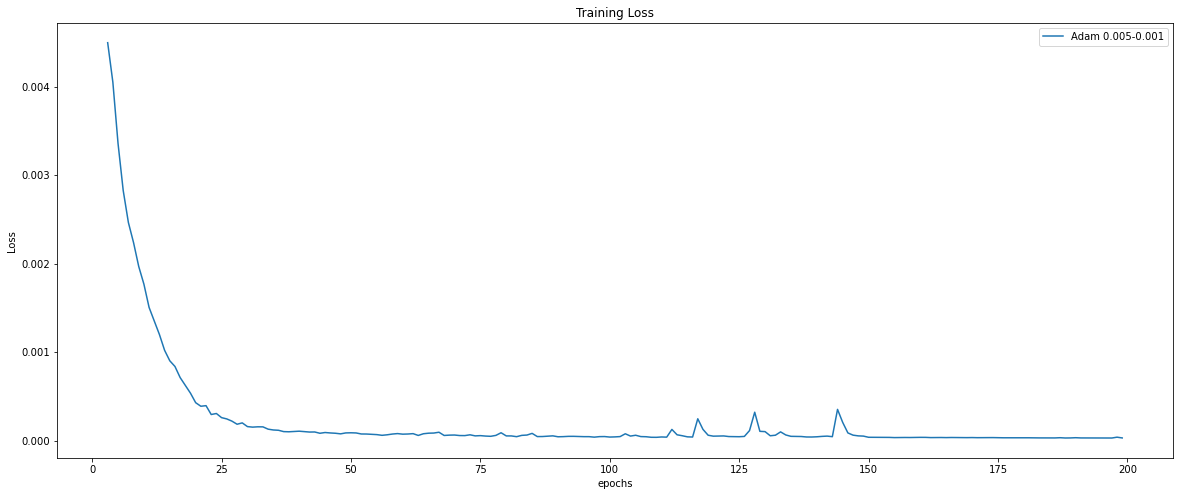

In [112]:
graphs_Adam_train = pd.DataFrame(loss_train, columns=['Adam 0.005-0.001'])
graphs_Adam_train.loc[3:].plot(figsize=(20,8), title='Training Loss', xlabel='epochs', ylabel='Loss')

<AxesSubplot:title={'center':'Testing Loss'}, xlabel='epochs', ylabel='Loss'>

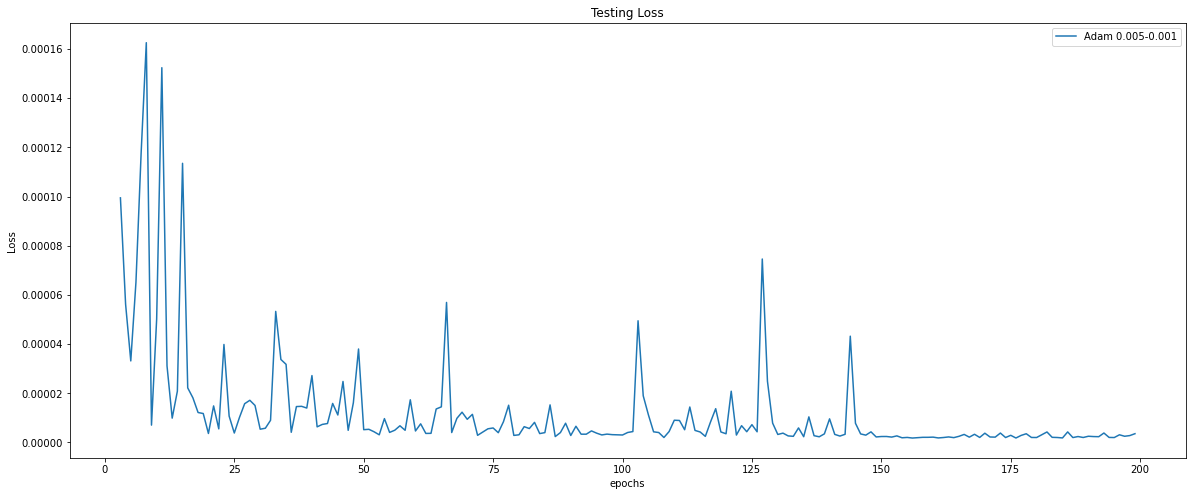

In [113]:
graphs_Adam_test = pd.DataFrame(loss_test, columns=['Adam 0.005-0.001'])
graphs_Adam_test.loc[3:].plot(figsize=(20,8), title='Testing Loss', xlabel='epochs', ylabel='Loss')

In [114]:
### Saving the model
path = os.getcwd() + '/aapl_predicting_model_5minute.dat'
torch.save(model, path)

In [115]:
### Loading the model
path = os.getcwd() + '/aapl_predicting_model_5minute.dat'
model_5min = torch.load(path)

In [116]:
x_to_predict, y_to_predict = data_to_predict(apple_set_5min, globalpar['test5']['structure'])
print(x_to_predict.shape, y_to_predict.shape)

(28795, 6, 4) (28795,)


In [117]:
predicted_apple = predicted_df(model_5min, x_to_predict, y_to_predict, globalpar['test5']['training'])
predicted_apple.tail(10)

,close,close_predicted
28785,0.772984,0.774124
28786,0.772825,0.774362
28787,0.773063,0.774250
28788,0.773143,0.774434
28789,0.772905,0.774577
28790,0.772905,0.774327
28791,0.772825,0.774259
28792,0.772667,0.774203
28793,0.772667,0.774038
28794,0.772825,0.774022


In [118]:
predicted_apple_denorm = de_normalize(predicted_apple, closescaler_5)

<AxesSubplot:>

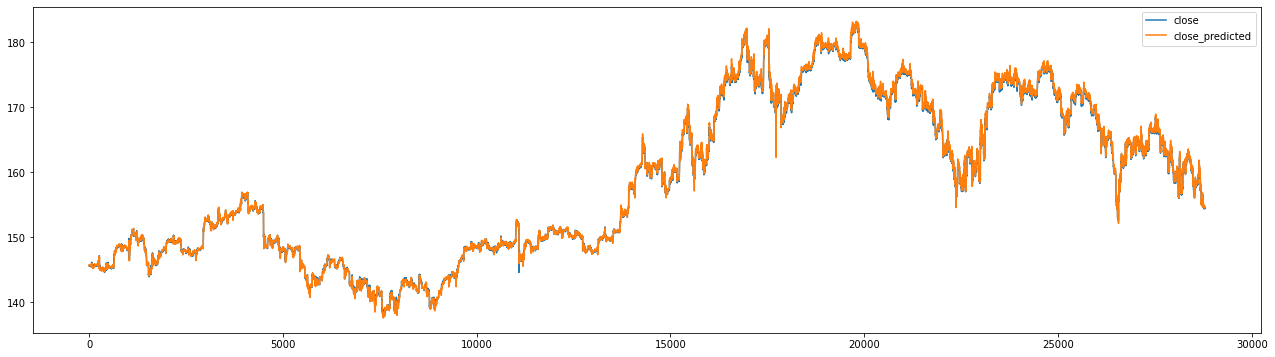

In [119]:
predicted_apple_denorm[:].plot(figsize=(22,6))

<AxesSubplot:>

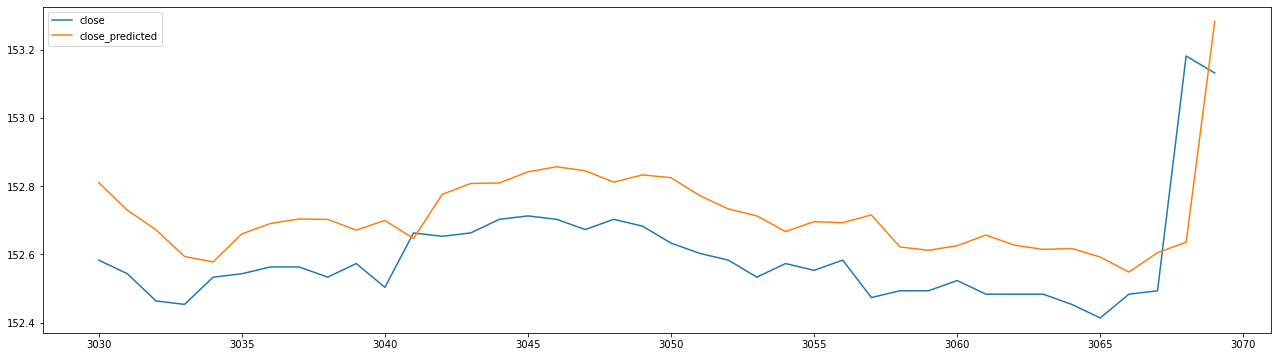

In [120]:
predicted_apple_denorm[3030:3070].plot(figsize=(22,6))

In [121]:
df5 = predicted_apple_denorm.copy()

<AxesSubplot:>

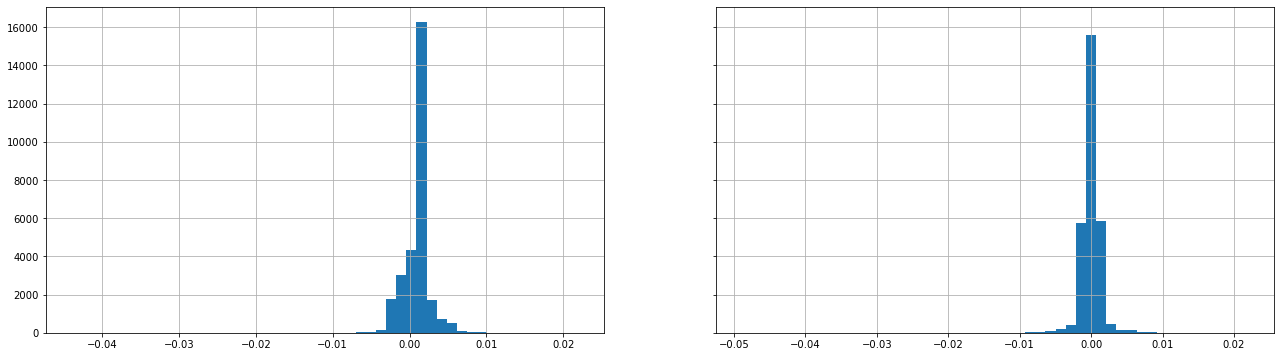

In [122]:
df5['diff'] = round((df5['close_predicted']-df5['close'].shift(2))/df5['close'].shift(1),3)
df5['real_diff'] = round((df5['close']-df5['close'].shift(1))/df5['close'].shift(1),3)

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(22, 6))
df5['diff'].hist(ax=ax[0], bins=50)
df5['real_diff'].hist(ax=ax[1], bins=50)

In [123]:
df5['real_diff'].value_counts()

 0.000    15574
 0.001     4574
-0.001     4545
 0.002     1259
-0.002     1227
 0.003      439
-0.003      398
-0.004      208
 0.004      167
 0.005       97
-0.005       77
 0.006       43
-0.006       40
 0.007       29
-0.007       26
 0.008       16
-0.008       13
-0.009        7
 0.009        7
 0.011        7
-0.011        6
 0.010        6
-0.012        5
-0.016        4
-0.010        4
-0.013        2
 0.016        2
 0.012        2
-0.020        2
-0.014        1
 0.013        1
 0.019        1
 0.017        1
-0.049        1
-0.026        1
 0.022        1
 0.015        1
Name: real_diff, dtype: int64

In [124]:
df5['diff'].value_counts()

 0.001    11452
 0.002     4811
 0.000     4335
-0.001     3006
 0.003     1722
-0.002     1400
 0.004      728
-0.003      369
 0.005      317
 0.006      174
-0.004      125
 0.007       90
-0.005       54
 0.008       50
 0.009       28
-0.007       21
 0.010       20
-0.006       17
-0.009       15
 0.011        8
-0.008        7
-0.010        6
 0.017        6
 0.014        5
-0.015        4
-0.012        3
 0.013        3
 0.012        3
 0.018        2
-0.013        2
 0.022        2
-0.024        1
-0.025        1
-0.039        1
-0.019        1
-0.044        1
 0.016        1
-0.020        1
-0.021        1
Name: diff, dtype: int64

In [125]:
minimum = 0.01

df5['success'] = df5['real_diff'] * (df5['diff']>=minimum) - df5['real_diff'] * (df5['diff']<=-minimum)

In [126]:
df5['success'].value_counts()

 0.000    28732
 0.001       11
-0.002       10
-0.001        8
 0.002        7
-0.003        6
 0.003        4
-0.005        3
 0.005        2
 0.004        2
-0.004        2
 0.010        1
 0.011        1
 0.007        1
 0.008        1
-0.008        1
-0.006        1
-0.015        1
Name: success, dtype: int64

In [127]:
print('Total benefit: {}, total trades: {}'.format(df5['success'].sum(), len(df5[df5['success']>0])))

Total benefit: -0.007000000000000001, total trades: 30


In [98]:
######### THIRD PART 30min GRAPHS ###################

apple_raw_30min = loading_ticker_data(globalpar['test30']['data'])

apple_raw_30min = filling_blank_periods_and_adding_market(apple_raw_30min, globalpar['test30']['data'])

apple_raw_30min = filling_nas(apple_raw_30min)
apple_pre_30min = apple_raw_30min.drop(columns=columns_to_drop)

apple_mom_30min = sma_and_momentum(apple_pre_30min, globalpar['test30']['data'])

apple_set_30min, volscaler_30, closescaler_30 = final_set(apple_mom_30min)

train_X, train_y, test_X, test_y = final_array(apple_set_30min, globalpar['test30']['structure'])

model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y,
                                              globalpar['test30']['training'])

Optimizer: Adam, Leaning rate: 0.001
Epoch[10/300] | loss train:0.00145350, test:0.00003382, learning rate: 0.001
Epoch[20/300] | loss train:0.00099477, test:0.00011297, learning rate: 0.001
Epoch[30/300] | loss train:0.00086193, test:0.00013266, learning rate: 0.001
Epoch[40/300] | loss train:0.00077028, test:0.00003302, learning rate: 0.001
Epoch[50/300] | loss train:0.00066862, test:0.00005049, learning rate: 0.001
Epoch[60/300] | loss train:0.00061565, test:0.00001481, learning rate: 0.001
Epoch[70/300] | loss train:0.00058584, test:0.00002445, learning rate: 0.001
Epoch[80/300] | loss train:0.00060155, test:0.00002409, learning rate: 0.001
Epoch[90/300] | loss train:0.00044500, test:0.00011212, learning rate: 0.001
Epoch[100/300] | loss train:0.00035570, test:0.00001514, learning rate: 0.001
Epoch[110/300] | loss train:0.00031040, test:0.00001729, learning rate: 0.001
Epoch[120/300] | loss train:0.00025025, test:0.00001231, learning rate: 0.001
Epoch[130/300] | loss train:0.000210

<AxesSubplot:title={'center':'Training Loss'}, xlabel='epochs', ylabel='Loss'>

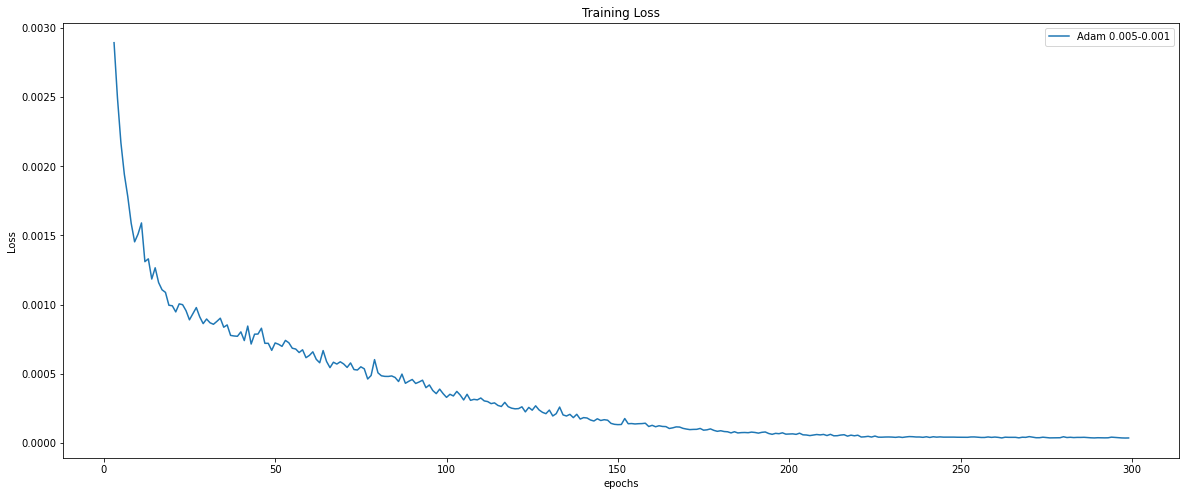

In [99]:
graphs_Adam_train = pd.DataFrame(loss_train, columns=['Adam 0.005-0.001'])
graphs_Adam_train.loc[3:].plot(figsize=(20,8), title='Training Loss', xlabel='epochs', ylabel='Loss')

<AxesSubplot:title={'center':'Testing Loss'}, xlabel='epochs', ylabel='Loss'>

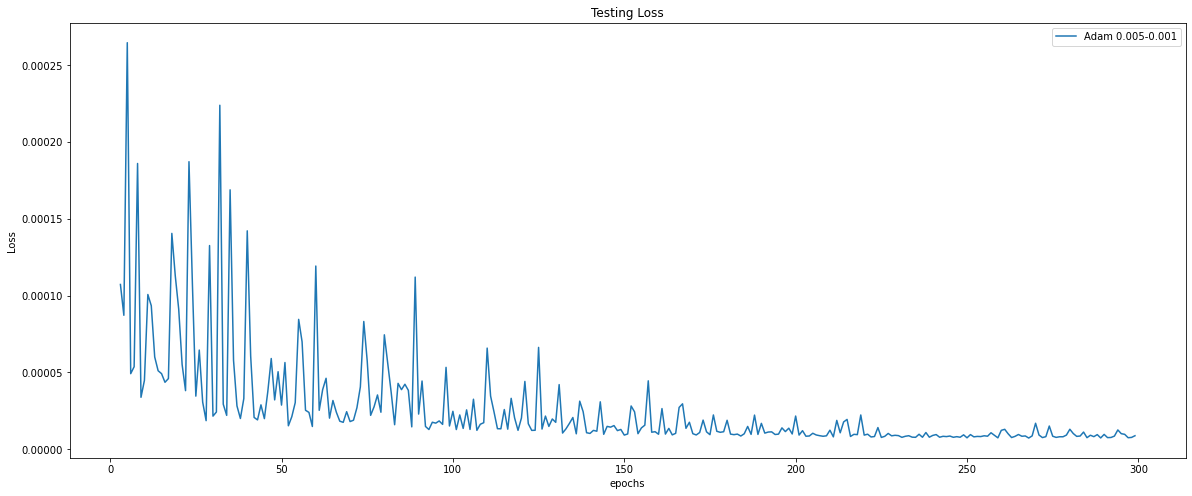

In [100]:
graphs_Adam_test = pd.DataFrame(loss_test, columns=['Adam 0.005-0.001'])
graphs_Adam_test.loc[3:].plot(figsize=(20,8), title='Testing Loss', xlabel='epochs', ylabel='Loss')

In [101]:
### Saving the model
path = os.getcwd() + '/aapl_predicting_model_30minute.dat'
torch.save(model, path)

In [102]:
### Loading the model
path = os.getcwd() + '/aapl_predicting_model_30minute.dat'
model_30min = torch.load(path)

In [103]:
x_to_predict, y_to_predict = data_to_predict(apple_set_30min, globalpar['test30']['structure'])
print(x_to_predict.shape, y_to_predict.shape)

(4769, 32, 4) (4769,)


In [104]:
predicted_apple = predicted_df(model_30min, x_to_predict, y_to_predict, globalpar['test30']['training'])
predicted_apple.tail(10)

,close,close_predicted
4759,0.781367,0.786408
4760,0.774808,0.783299
4761,0.771951,0.777071
4762,0.772545,0.767777
4763,0.769457,0.772796
4764,0.770905,0.772659
4765,0.771066,0.772530
4766,0.769135,0.771710
4767,0.770020,0.769710
4768,0.770181,0.769660


In [105]:
predicted_apple_denorm = de_normalize(predicted_apple, closescaler_30)

<AxesSubplot:>

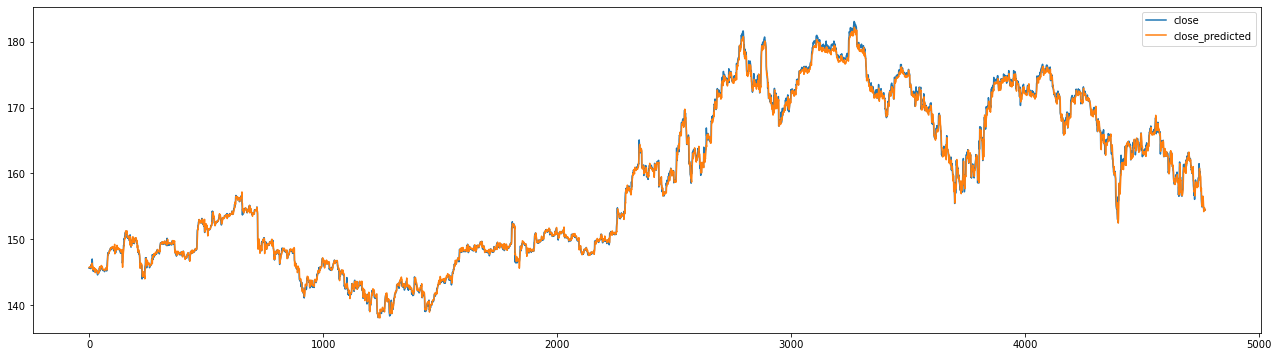

In [106]:
predicted_apple_denorm[:].plot(figsize=(22,6))

<AxesSubplot:>

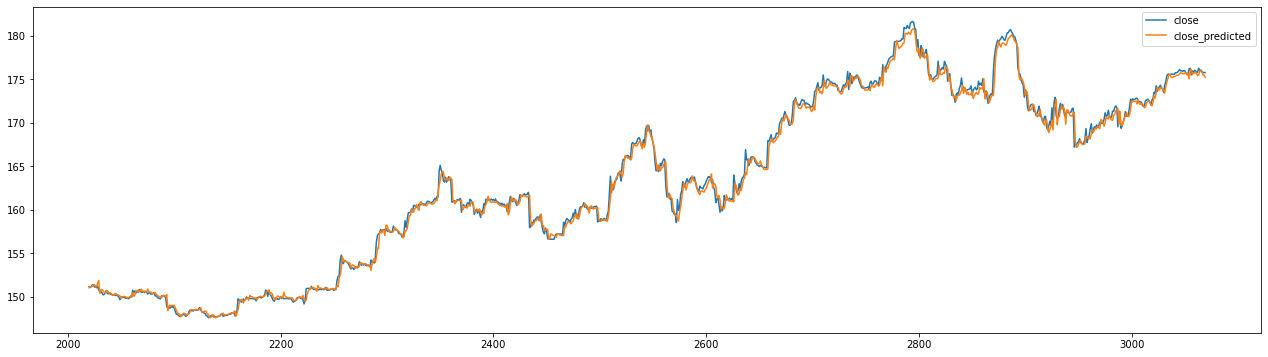

In [107]:
predicted_apple_denorm[2020:3070].plot(figsize=(22,6))

<AxesSubplot:>

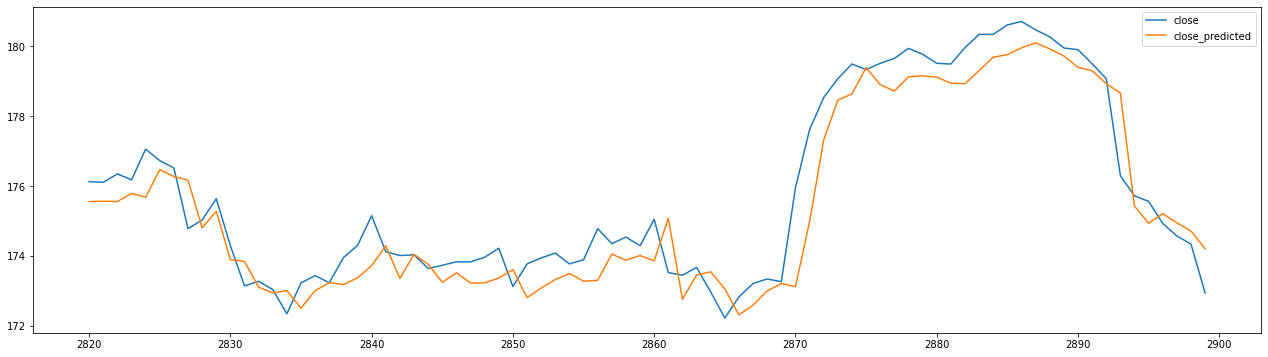

In [108]:
predicted_apple_denorm[2820:2900].plot(figsize=(22,6))

In [109]:
df30 = predicted_apple_denorm.copy()

<AxesSubplot:>

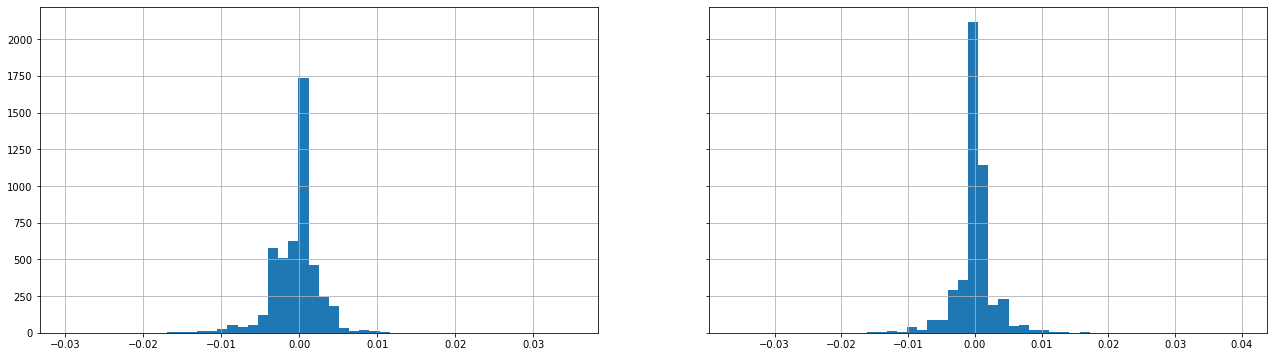

In [110]:
df30['diff'] = round((df30['close_predicted']-df30['close'].shift(2))/df30['close'].shift(1),3)
df30['real_diff'] = round((df30['close']-df30['close'].shift(1))/df30['close'].shift(1),3)

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(22, 6))
df30['diff'].hist(ax=ax[0], bins=50)
df30['real_diff'].hist(ax=ax[1], bins=50)

In [111]:
df30['real_diff'].value_counts()

-0.000    1352
-0.001     764
 0.001     752
 0.002     392
-0.002     361
 0.003     191
-0.003     188
 0.004     148
-0.004     101
-0.005      86
 0.005      85
-0.006      48
 0.006      47
-0.007      37
 0.007      35
-0.008      21
-0.009      21
 0.009      20
-0.010      16
 0.008      15
-0.012      11
 0.011       9
 0.010       9
 0.012       7
-0.011       7
 0.013       4
-0.015       4
-0.016       4
-0.013       4
-0.014       3
 0.017       3
 0.014       3
 0.016       3
 0.018       2
 0.015       2
-0.025       2
-0.026       1
 0.040       1
-0.018       1
-0.019       1
 0.019       1
 0.025       1
-0.017       1
 0.023       1
-0.036       1
 0.021       1
 0.026       1
Name: real_diff, dtype: int64

In [112]:
df30['diff'].value_counts()

 0.001    914
 0.000    822
-0.001    624
-0.002    509
 0.002    465
-0.003    354
 0.003    243
-0.004    221
 0.004    130
-0.005    123
 0.005     55
-0.006     55
-0.007     42
 0.006     35
-0.008     33
-0.010     25
-0.009     19
 0.007     14
 0.010     11
-0.011     11
 0.008     10
-0.012      8
 0.009      8
-0.016      5
-0.013      5
-0.014      4
 0.011      3
-0.015      3
-0.018      2
 0.012      2
-0.017      2
 0.017      1
-0.020      1
 0.013      1
 0.035      1
-0.023      1
-0.030      1
-0.029      1
 0.018      1
 0.014      1
-0.021      1
Name: diff, dtype: int64

In [116]:
minimum = 0.005

df30['success'] = df30['real_diff'] * (df30['diff']>=minimum) - df30['real_diff'] * (df30['diff']<=-minimum)

In [117]:
df30['success'].value_counts()

 0.000    4352
 0.001      72
-0.002      42
 0.003      38
-0.001      37
 0.002      36
-0.003      26
-0.004      22
 0.004      21
 0.005      20
-0.005      14
 0.006      14
-0.006      11
 0.007       9
-0.008       8
 0.008       6
 0.010       5
-0.009       5
-0.007       5
-0.010       4
 0.009       4
-0.011       3
-0.012       3
 0.012       3
 0.011       2
 0.013       1
 0.016       1
 0.019       1
 0.040       1
 0.015       1
-0.026       1
Name: success, dtype: int64

In [118]:
print('Total benefit: {}, total trades: {}'.format(df30['success'].sum(), len(df30[df30['success']>0])))

Total benefit: 0.18200000000000002, total trades: 235


In [119]:
### Let's check for accuracy about going up or down:
apple_raw_3xmin = loading_ticker_data(globalpar['test30']['data'])

In [144]:
apple_mom_30min[-40:]

,market,close,volume,sma,momentum
2022-03-10 16:30:00,0,158.2200,3799958.0,159.716725,-0.053520
2022-03-10 17:00:00,0,158.1900,167804.0,159.577037,-0.073940
2022-03-10 17:30:00,0,157.9600,36735.0,159.435475,-0.094316
2022-03-10 18:00:00,0,158.0000,25598.0,159.294850,-0.114686
2022-03-10 18:30:00,0,158.3000,44001.0,159.181100,-0.131793
2022-03-10 19:00:00,0,158.3600,37149.0,159.068287,-0.148313
2022-03-10 19:30:00,0,158.4700,55846.0,158.954225,-0.164232
2022-03-10 20:00:00,0,158.0500,41432.0,158.822975,-0.181327
2022-03-11 04:30:00,0,159.1500,17900.0,158.748600,-0.188542
2022-03-11 05:00:00,0,159.3700,14647.0,158.697975,-0.191847


In [139]:
df30

,close,close_predicted,diff,real_diff,success
0,145.632094,145.734737,NaN,NaN,NaN
1,145.622118,145.748002,NaN,-0.000,0.0
2,145.751764,145.744817,0.001,0.001,0.0
3,145.691929,145.838291,0.001,-0.000,0.0
4,145.662008,145.828063,0.001,-0.000,0.0
...,...,...,...,...,...
4764,154.599997,154.817925,0.000,0.001,0.0
4765,154.620001,154.801958,0.002,0.000,0.0
4766,154.380003,154.699996,0.001,-0.002,0.0
4767,154.490000,154.451458,-0.001,0.001,0.0


In [195]:
######### THIRD PART 60min GRAPHS ###################

dropouts = [0.20, 0.30]
epochs = 100
lrs = [[0.01, 0.005, 0.001, 0.0005], [0.005, 0.001, 0.0005, 0.0001]]
groups = [2400, 4800, 7200]

globalpar['test60']['training']['epochs'] = 120
globalpar['test60']['training']['epochs_change'] = 35
            
for group in groups:
    for lr in lrs:
        for drop in dropouts:
            
            globalpar['test60']['training']['lrs'] = lr
            globalpar['test60']['structure']['total_size'] = group
            globalpar['test60']['training']['model_dropout'] = drop
            
            print(lr, group, drop)

            apple_raw_60min = loading_ticker_data(globalpar['test60']['data'])

            apple_raw_60min = filling_blank_periods_and_adding_market(apple_raw_60min, globalpar['test60']['data'])

            apple_raw_60min = filling_nas(apple_raw_60min)

            apple_pre_60min = apple_raw_60min.drop(columns=columns_to_drop)

            apple_mom_60min = sma_and_momentum(apple_pre_60min, globalpar['test60']['data'])

            apple_set_60min, volscaler_60, closescaler_60 = final_set(apple_mom_60min)

            train_X, train_y, test_X, test_y = final_array(apple_set_60min, globalpar['test60']['structure'])

            model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y,
                                                          globalpar['test60']['training'])

[0.01, 0.005, 0.001, 0.0005] 2400 0.2
Optimizer: Adam, Leaning rate: 0.01
Epoch[10/120] | loss train:0.00064945, test:0.00204480, learning rate: 0.01
Epoch[20/120] | loss train:0.00045227, test:0.00004048, learning rate: 0.01
Epoch[30/120] | loss train:0.00035048, test:0.00002251, learning rate: 0.01
Epoch[40/120] | loss train:0.00025443, test:0.00001980, learning rate: 0.005
Epoch[50/120] | loss train:0.00024266, test:0.00001330, learning rate: 0.005
Epoch[60/120] | loss train:0.00028732, test:0.00022896, learning rate: 0.005
Epoch[70/120] | loss train:0.00023419, test:0.00010210, learning rate: 0.005
Epoch[80/120] | loss train:0.00018130, test:0.00010983, learning rate: 0.001
Epoch[90/120] | loss train:0.00017391, test:0.00002488, learning rate: 0.001
Epoch[100/120] | loss train:0.00018091, test:0.00001089, learning rate: 0.001
Epoch[110/120] | loss train:0.00016622, test:0.00002055, learning rate: 0.0005
Epoch[120/120] | loss train:0.00015678, test:0.00001557, learning rate: 0.0005


In [200]:
######### FINAL PART 60min GRAPHS ###################

apple_raw_60min = loading_ticker_data(globalpar['test60']['data'])

apple_raw_60min = filling_blank_periods_and_adding_market(apple_raw_60min, globalpar['test60']['data'])

apple_raw_60min = filling_nas(apple_raw_60min)

apple_pre_60min = apple_raw_60min.drop(columns=columns_to_drop)

apple_mom_60min = sma_and_momentum(apple_pre_60min, globalpar['test60']['data'])

apple_set_60min, volscaler_60, closescaler_60 = final_set(apple_mom_60min)

train_X, train_y, test_X, test_y = final_array(apple_set_60min, globalpar['test60']['structure'])

model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y,
                                              globalpar['test60']['training'])

Optimizer: Adam, Leaning rate: 0.005
Epoch[10/300] | loss train:0.00029552, test:0.00013361, learning rate: 0.005
Epoch[20/300] | loss train:0.00022083, test:0.00003979, learning rate: 0.005
Epoch[30/300] | loss train:0.00013083, test:0.00008281, learning rate: 0.005
Epoch[40/300] | loss train:0.00010237, test:0.00012490, learning rate: 0.005
Epoch[50/300] | loss train:0.00009361, test:0.00019780, learning rate: 0.005
Epoch[60/300] | loss train:0.00007916, test:0.00010219, learning rate: 0.005
Epoch[70/300] | loss train:0.00005408, test:0.00003366, learning rate: 0.005
Epoch[80/300] | loss train:0.00004883, test:0.00010927, learning rate: 0.005
Epoch[90/300] | loss train:0.00005032, test:0.00003273, learning rate: 0.005
Epoch[100/300] | loss train:0.00004763, test:0.00007196, learning rate: 0.005
Epoch[110/300] | loss train:0.00003996, test:0.00014201, learning rate: 0.005
Epoch[120/300] | loss train:0.00004372, test:0.00006544, learning rate: 0.005
Epoch[130/300] | loss train:0.000027

<AxesSubplot:title={'center':'Training Loss'}, xlabel='epochs', ylabel='Loss'>

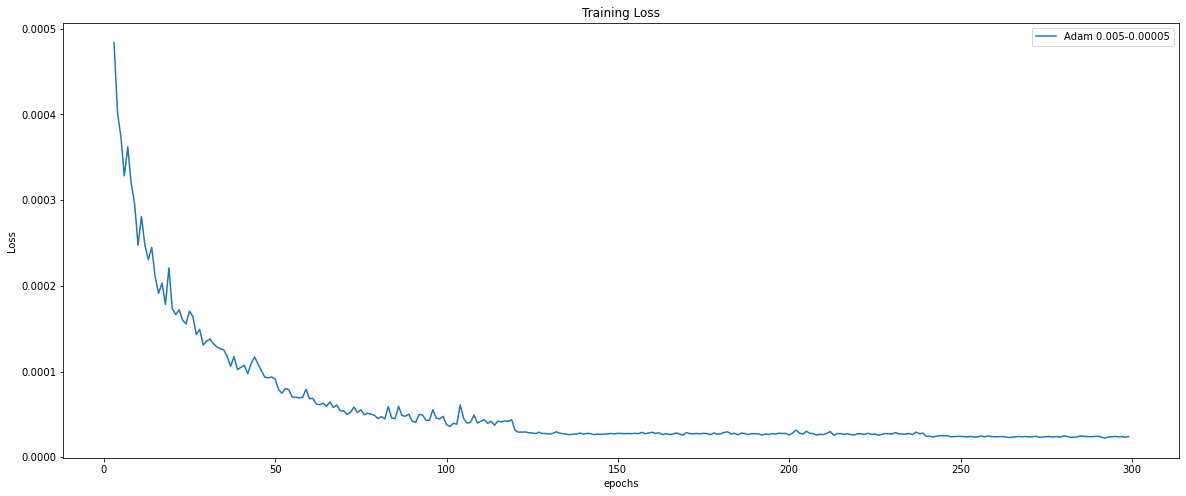

In [201]:
graphs_Adam_train = pd.DataFrame(loss_train, columns=['Adam 0.005-0.00005'])
graphs_Adam_train.loc[3:].plot(figsize=(20,8), title='Training Loss', xlabel='epochs', ylabel='Loss')

<AxesSubplot:title={'center':'Testing Loss'}, xlabel='epochs', ylabel='Loss'>

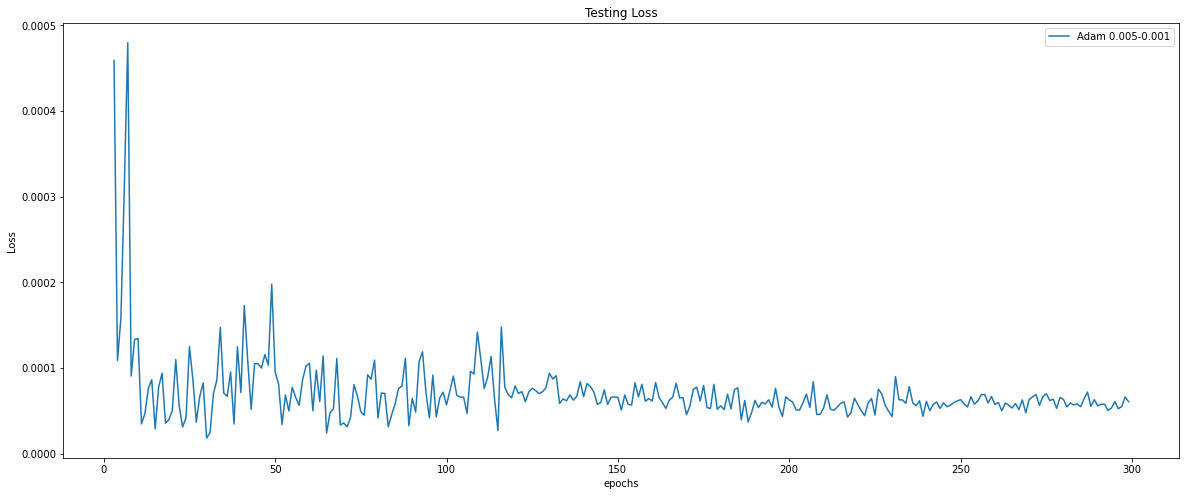

In [202]:
graphs_Adam_test = pd.DataFrame(loss_test, columns=['Adam 0.005-0.001'])
graphs_Adam_test.loc[3:].plot(figsize=(20,8), title='Testing Loss', xlabel='epochs', ylabel='Loss')

In [203]:
### Saving the model
path = os.getcwd() + '/aapl_predicting_model_60minute.dat'
torch.save(model, path)

In [207]:
### Loading the model
path = os.getcwd() + '/aapl_predicting_model_60minute.dat'
model_60min = torch.load(path)

In [210]:
x_to_predict, y_to_predict = data_to_predict(apple_set_60min, globalpar['test60']['structure'])
print(x_to_predict.shape, y_to_predict.shape)

(7105, 64, 4) (7105,)


In [211]:
predicted_apple = predicted_df(model_60min, x_to_predict, y_to_predict, globalpar['test60']['training'])
predicted_apple.tail(10)

,close,close_predicted
7095,0.784637,0.770702
7096,0.793484,0.775506
7097,0.790690,0.783310
7098,0.784133,0.784408
7099,0.784514,0.777120
7100,0.782498,0.779935
7101,0.803295,0.770262
7102,0.804889,0.788749
7103,0.803128,0.790463
7104,0.799857,0.785628


In [212]:
predicted_apple_denorm = de_normalize(predicted_apple, closescaler_60)

<AxesSubplot:>

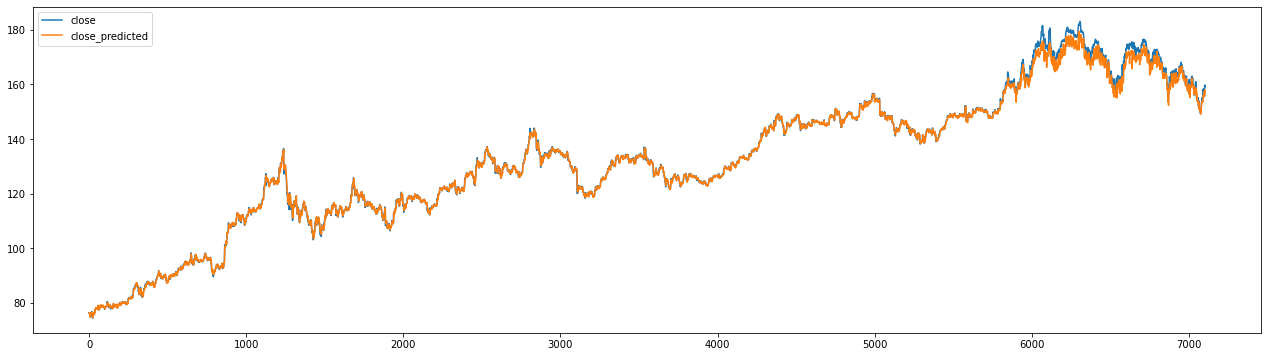

In [213]:
predicted_apple_denorm[:].plot(figsize=(22,6))

<AxesSubplot:>

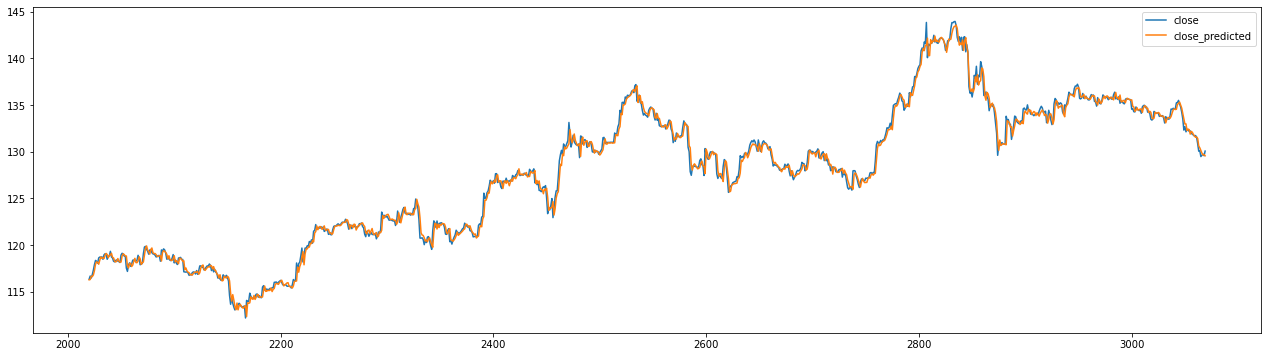

In [214]:
predicted_apple_denorm[2020:3070].plot(figsize=(22,6))

<AxesSubplot:>

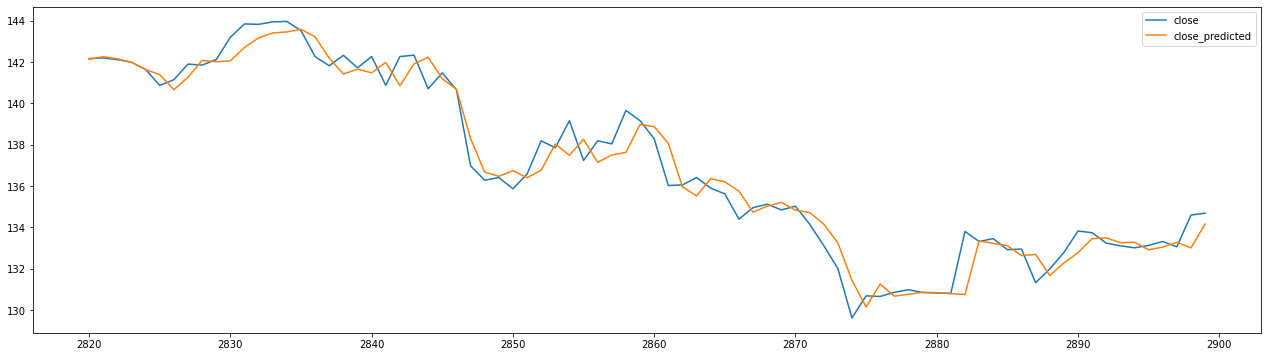

In [215]:
predicted_apple_denorm[2820:2900].plot(figsize=(22,6))

In [216]:
df60 = predicted_apple_denorm.copy()

<AxesSubplot:>

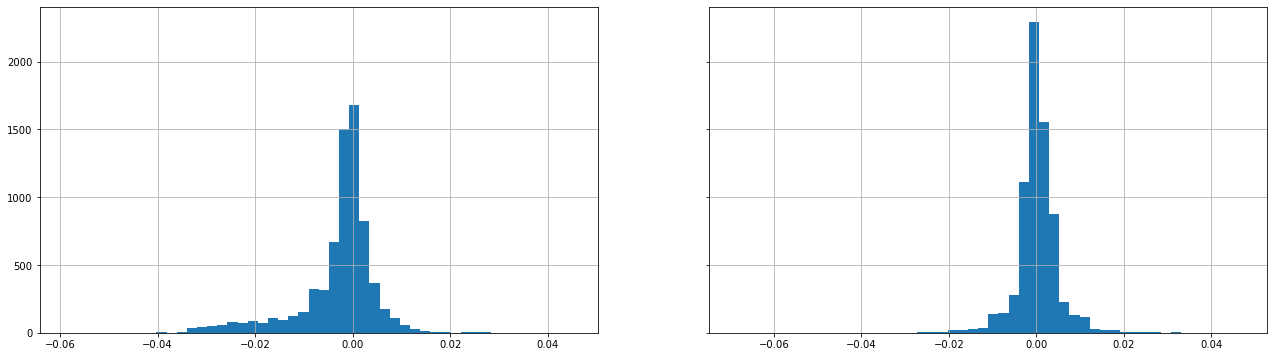

In [217]:
df60['diff'] = round((df60['close_predicted']-df60['close'].shift(2))/df60['close'].shift(1),3)
df60['real_diff'] = round((df60['close']-df60['close'].shift(1))/df60['close'].shift(1),3)

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(22, 6))
df60['diff'].hist(ax=ax[0], bins=50)
df60['real_diff'].hist(ax=ax[1], bins=50)

In [219]:
df60['real_diff'].value_counts()

 0.000    1385
 0.001     930
-0.001     906
 0.002     627
-0.002     537
          ... 
 0.021       1
-0.033       1
-0.069       1
 0.047       1
 0.027       1
Name: real_diff, Length: 66, dtype: int64

In [220]:
df60['diff'].value_counts()

-0.000    945
-0.001    915
 0.001    738
-0.002    587
 0.002    465
         ... 
 0.023      1
-0.049      1
-0.059      1
-0.056      1
-0.042      1
Name: diff, Length: 78, dtype: int64

In [236]:
minimum = 0.008

df60['success'] = df60['real_diff'] * (df60['diff']>=minimum) - df60['real_diff'] * (df60['diff']<=-minimum)

In [237]:
df60['success'].value_counts()

 0.000    5852
-0.001     168
 0.001     154
-0.002     122
 0.002     111
-0.003      79
 0.003      77
-0.004      62
 0.004      58
-0.005      44
 0.005      38
-0.006      33
 0.007      30
-0.007      28
 0.006      25
-0.008      21
 0.008      19
 0.009      19
-0.009      18
-0.010      13
 0.011      13
 0.010      12
 0.014      10
-0.012       9
 0.016       6
-0.011       6
 0.012       6
-0.013       5
-0.019       5
 0.015       5
-0.016       5
 0.018       5
 0.013       4
-0.018       4
-0.015       4
-0.014       3
 0.024       3
 0.019       3
 0.017       3
 0.020       2
-0.020       2
 0.023       2
 0.026       2
-0.023       2
 0.028       2
-0.017       2
-0.031       1
-0.025       1
 0.022       1
 0.040       1
 0.021       1
-0.038       1
-0.028       1
 0.033       1
Name: success, dtype: int64

In [238]:
print('Total benefit: {}, total trades: {}'.format(df60['success'].sum(), len(df60[df60['success']>0])))

Total benefit: 0.18899999999999995, total trades: 613


In [544]:
######### FIXING LAG GRAPHS ###################
globalpar['testX'] = {
        'data' : {
            'ticker' : 'AAPL',
            'interval' : '1min',
            'minutes' : 1,
            'sma_range' : 30, ## A half hour
            
        },
        'structure' : {
            'training_size' : 0.8,
            'test_size' : 0.2,
            'total_size' : 2400,
            'sequence_size' : 30,
            'batch_size' : 32,
            'input_size' : 4,
        },
        'training' : {
            'sequence_size' : 30,
            'batch_size' : 32,
            'model_input_size' : 4,
            'model_lstm_layers' : 3,
            'model_lstm_size' : 256,
            'model_dropout' : 0.2,
            'model_output' : 1,
            'epochs' : 250,
            'optimizer' : 'Adam', 
            'lrs': [0.005, 0.001, 0.0005, 0.0001],
            'lr_change': True,
            'epochs_change' : 200
        }
    }

apple_raw_Xmin = loading_ticker_data(globalpar['test1']['data'])

apple_raw_Xmin = filling_blank_periods_and_adding_market(apple_raw_Xmin, globalpar['testX']['data'])

apple_raw_Xmin = filling_nas(apple_raw_Xmin)

apple_pre_Xmin = apple_raw_Xmin.drop(columns=columns_to_drop)

apple_mom_Xmin = sma_and_momentum(apple_pre_Xmin, globalpar['testX']['data'])

apple_set_Xmin, volscaler_X, closescaler_X = final_set(apple_mom_Xmin)
print(apple_set_Xmin[-960:])
train_X, train_y, test_X, test_y = final_array(apple_set_Xmin, globalpar['testX']['structure'])
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y,
                                              globalpar['testX']['training'])

                     market     close    volume  momentum      next
2022-03-10 20:00:00    -1.0  0.800998 -0.446900 -0.006944  0.800998
2022-03-11 04:01:00    -1.0  0.800998 -0.471690 -0.008059  0.803775
2022-03-11 04:02:00    -1.0  0.803775 -0.469654 -0.008354  0.803775
2022-03-11 04:03:00    -1.0  0.803775 -0.471690 -0.008754  0.803775
2022-03-11 04:04:00    -1.0  0.803775 -0.471690 -0.009153  0.803775
...                     ...       ...       ...       ...       ...
2022-03-11 19:55:00    -1.0  0.772825 -0.471690 -0.001229  0.772428
2022-03-11 19:56:00    -1.0  0.772428 -0.469941 -0.001359  0.772428
2022-03-11 19:57:00    -1.0  0.772428 -0.466348 -0.001531  0.772667
2022-03-11 19:58:00    -1.0  0.772667 -0.452855 -0.001877  0.772428
2022-03-11 19:59:00    -1.0  0.772428 -0.460864 -0.002286  0.772349

[960 rows x 5 columns]
dataset len: 2430
total_batches: 75
total_test_batches: 15
total_train_batches: 60
-2429 -480 -509
train values shape: (1949, 5), test values shape: (509, 5)
tr

<AxesSubplot:title={'center':'Training Loss'}, xlabel='epochs', ylabel='Loss'>

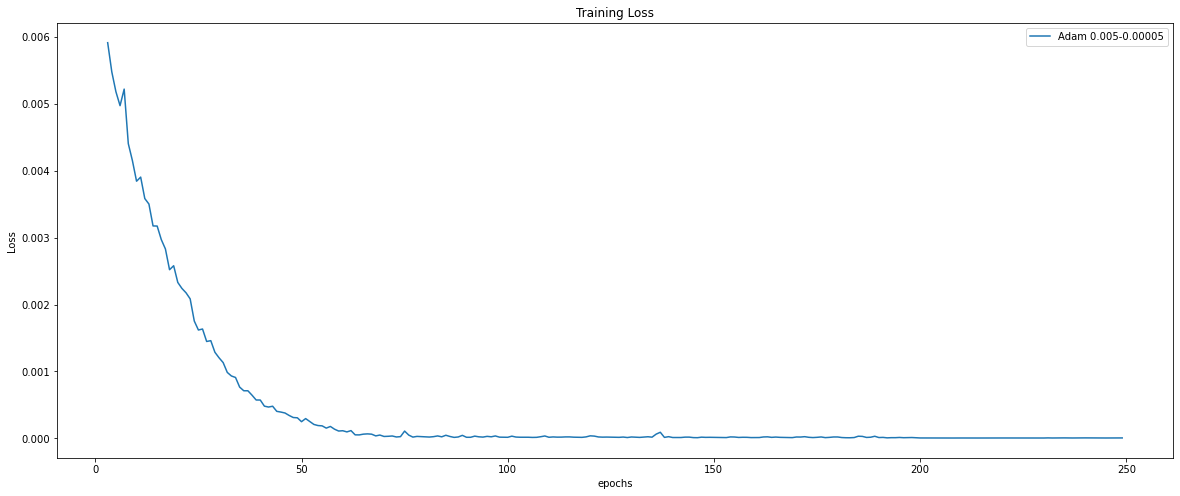

In [531]:
graphs_Adam_train = pd.DataFrame(loss_train, columns=['Adam 0.005-0.00005'])
graphs_Adam_train.loc[3:].plot(figsize=(20,8), title='Training Loss', xlabel='epochs', ylabel='Loss')

<AxesSubplot:title={'center':'Testing Loss'}, xlabel='epochs', ylabel='Loss'>

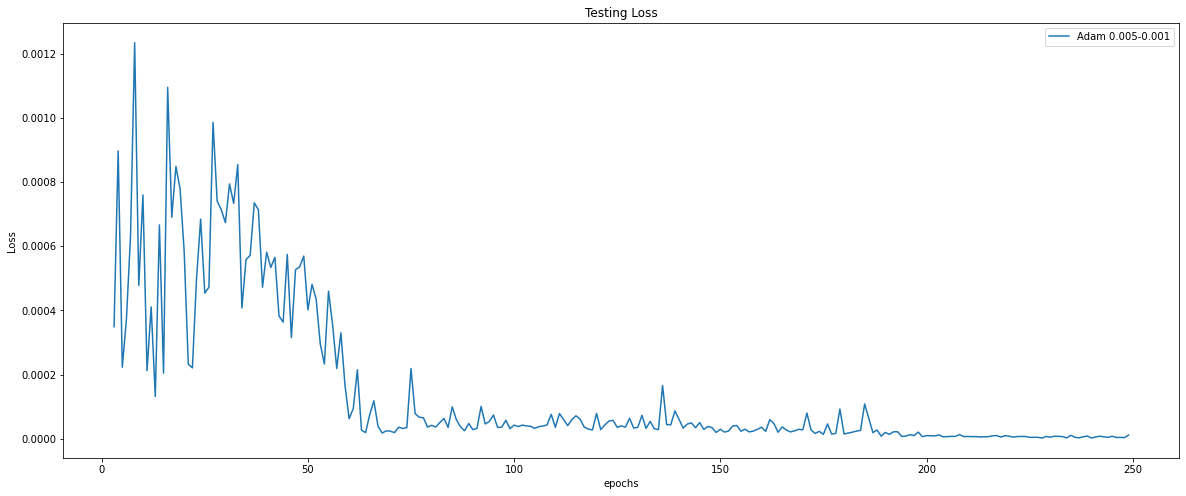

In [532]:
graphs_Adam_test = pd.DataFrame(loss_test, columns=['Adam 0.005-0.001'])
graphs_Adam_test.loc[3:].plot(figsize=(20,8), title='Testing Loss', xlabel='epochs', ylabel='Loss')

In [533]:
x_to_predict, y_to_predict = data_to_predict(apple_set_Xmin, globalpar['testX']['structure'])
print(x_to_predict.shape, y_to_predict.shape)

(2371, 30, 4) (2371,)


In [538]:
predicted_apple = predicted_df(model, x_to_predict, y_to_predict, globalpar['testX']['training'])
predicted_apple.tail(10)

,close,close_predicted
2361,0.772667,0.778791
2362,0.772349,0.778870
2363,0.772825,0.778714
2364,0.772825,0.778956
2365,0.772825,0.779101
2366,0.772825,0.779081
2367,0.772428,0.779014
2368,0.772428,0.778708
2369,0.772667,0.778616
2370,0.772428,0.778807


In [539]:
predicted_apple_denorm = de_normalize(predicted_apple, closescaler_X)

<AxesSubplot:>

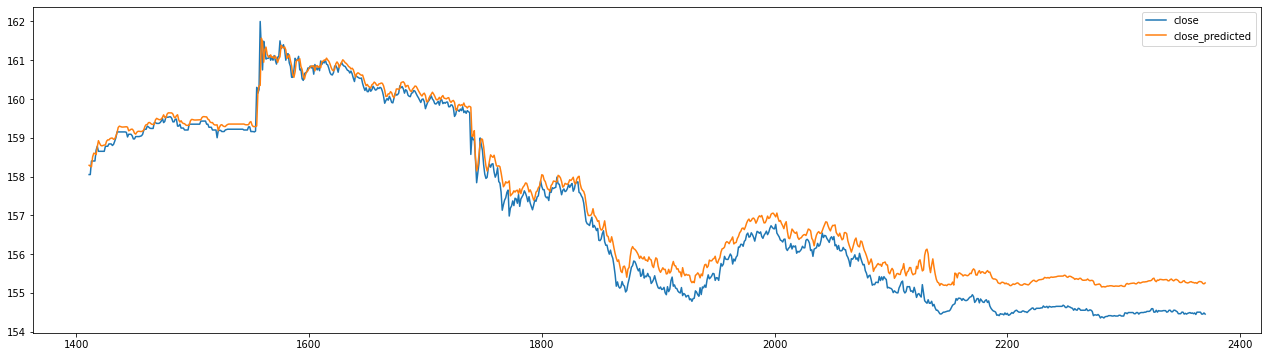

In [540]:
predicted_apple_denorm[-960:].plot(figsize=(22,6))

<AxesSubplot:>

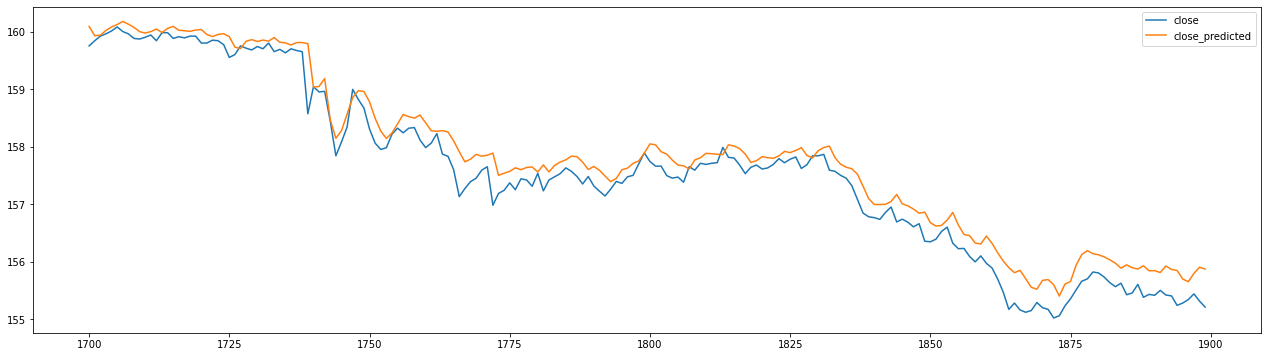

In [541]:
predicted_apple_denorm[1700:1900].plot(figsize=(22,6))
#predicted_apple_denorm[4100:4550]['close_predicted'].shift(-1).plot(figsize=(22,6))

<AxesSubplot:>

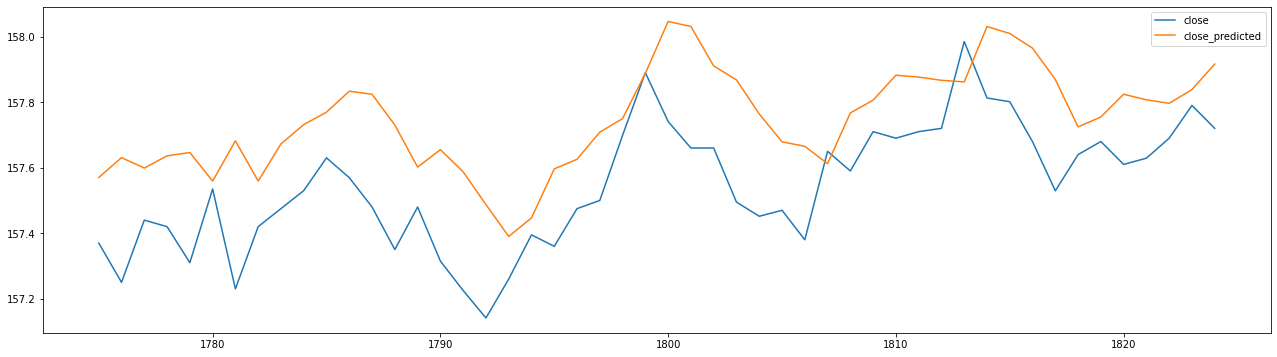

In [542]:
predicted_apple_denorm[1775:1825].plot(figsize=(22,6))
#predicted_apple_denorm[4190:4240]['close_predicted'].shift(-1).plot(figsize=(22,6))

<AxesSubplot:>

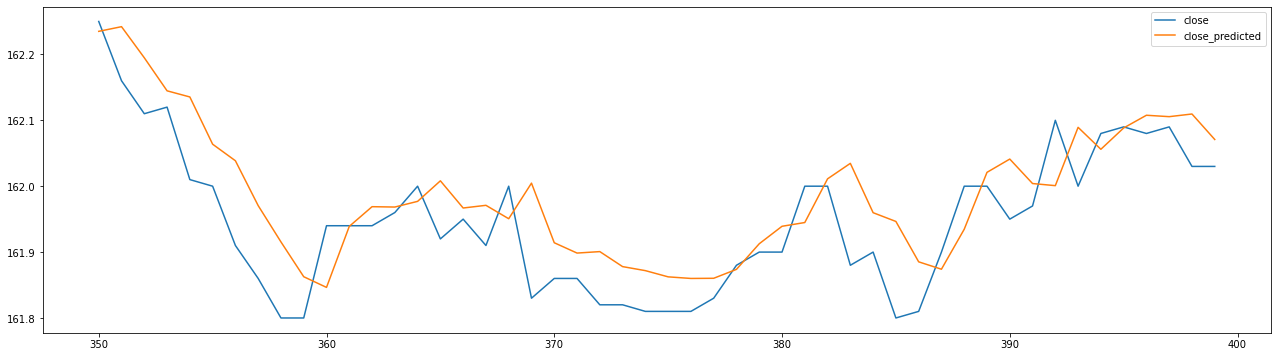

In [543]:
predicted_apple_denorm[350:400].plot(figsize=(22,6))

In [19]:
from statsmodels.tsa.stattools import adfuller
def checking_adf(data, size, maxlags=60):
    adf = {}
    for col in data.columns:
        adf[col] = adfuller(data[-size:][col], maxlag=maxlags, autolag=None)
    adf_df = pd.DataFrame(adf).transpose()
    adf_df['1%'] = adf_df.loc[:,4].apply(lambda x: x['1%'])
    adf_df['5%'] = adf_df.loc[:,4].apply(lambda x: x['5%'])
    adf_df['10%'] = adf_df.loc[:,4].apply(lambda x: x['10%'])
    adf_df.drop(columns=[3,4], inplace=True)
    adf_df.rename(columns={0:'ADF', 1: 'p-value', 2:'n_lags'}, inplace=True)
    adf_df['stationary'] = adf_df.loc[:,'ADF'] < adf_df.loc[:,'5%']
    return(adf_df)

In [526]:
globalpar = {
    'test1' : {
        'data' : {
            'ticker' : 'AAPL',
            'interval' : '1min',
            'minutes' : 1,
            'sma_range' : 30, ## A half hour
            
        },
        'structure' : {
            'training_size' : 0.8,
            'test_size' : 0.2,
            'total_size' : 38400,
            'sequence_size' : 20,
            'batch_size' : 64,
            'input_size' : 4,
            'weight_decay' : 0.
        },
        'training' : {
            'sequence_size' : 20,
            'batch_size' : 64,
            'model_input_size' : 4,
            'model_lstm_layers' : 3,
            'model_lstm_size' : 128,
            'model_dropout' : 0.15,
            'model_output' : 1,
            'epochs' : 600,
            'optimizer' : 'Adam', 
            'lrs': [0.001, 0.0001, 0.00001],
            'lr_change': True,
            'epochs_change' : 450,
            'weight_decay' : 0.
        },
    },
}

In [527]:
from scipy import stats

columns_to_drop = ['open', 'high', 'low']

apple_raw_Xmin = loading_ticker_data(globalpar['test1']['data'])

apple_raw_Xmin = filling_blank_periods_and_adding_market(apple_raw_Xmin, globalpar['test1']['data'])

apple_raw_Xmin = filling_nas(apple_raw_Xmin)

apple_pre_Xmin = apple_raw_Xmin.drop(columns=columns_to_drop)

#apple_momx_Xmin = apple_pre_Xmin

'''momentum = 20#globalpar['test1']['data']['sma_range']
apple_momx_Xmin['sma'] = apple_momx_Xmin.close.rolling(momentum).mean()
apple_momx_Xmin['momentum'] = 100 * np.log(apple_momx_Xmin['sma'] / apple_momx_Xmin['sma'].shift(momentum))
apple_mom_Xmin = apple_momx_Xmin.iloc[momentum * 2:]'''

apple_mom_Xmin = sma_and_momentum(apple_pre_Xmin.copy(), globalpar['test1']['data'])

apple_mom_Xmin['close'] = 100 * (np.log(apple_pre_Xmin['close']/apple_pre_Xmin['close'].shift(1)))

#apple_mom_Xmin['close'] = 10 * ((apple_pre_Xmin['close'] - apple_pre_Xmin['close'].shift(1)))

#apple_mom_Xmin['close'], _ = stats.yeojohnson(apple_mom_Xmin['close'].dropna())


apple_mom_Xmin['volume'], _ = stats.boxcox(apple_mom_Xmin['volume']+1)
## FIRST ORDER DIFFERENCING FOR VOLUME
apple_mom_Xmin['volume'] = apple_mom_Xmin['volume'] - apple_mom_Xmin['volume'].shift(960)
## SECOND ORDER DIFFERENCING FOR VOLUME
apple_mom_Xmin['volume'] = apple_mom_Xmin['volume'] - apple_mom_Xmin['volume'].shift(1)

#scaler_vol = StandardScaler()
scaler_vol = MinMaxScaler(feature_range=(-1, 1))

apple_mom_Xmin['volume'] = scaler_vol.fit_transform(np.array(apple_mom_Xmin['volume']).reshape(-1,1))

#scaler_close = MinMaxScaler(feature_range=(-1, 1))
#scaler_close = StandardScaler()

#apple_mom_Xmin['close'] = scaler_close.fit_transform(np.array(apple_mom_Xmin['close']).reshape(-1,1))
#apple_mom_Xmin['close'], _ = stats.boxcox(apple_mom_Xmin['close'])

#apple_mom_Xmin['momentum'] = 1000 * ((apple_mom_Xmin['momentum']) - (apple_mom_Xmin['momentum'].shift(1)))

#scaler_mom = MinMaxScaler()

#apple_mom_Xmin['momentum'] = scaler_mom.fit_transform(np.array(apple_mom_Xmin['momentum']).reshape(-1,1))

#apple_mom_Xmin['open_market'] = ((apple_mom_Xmin['market'] + 1) / 2)
#apple_mom_Xmin['close_market'] = (abs(apple_mom_Xmin['market'] - 1) / 2)


    # Lets add the resulting column or the next minute price
apple_mom_Xmin['next'] = apple_mom_Xmin['close'].shift(-1)
    # Guarantee we have all in float32 data type
for col in apple_mom_Xmin.columns:
    apple_mom_Xmin[col] = apple_mom_Xmin[col].astype('float32')

to_drop = ['sma']#, 'volume', 'market', 'momentum']
    
apple_mom_Xmin.drop(columns=to_drop, inplace=True)

#apple_mom_Xmin.drop(columns='market', inplace=True)

#apple_mom_Xmin.drop(columns='close', inplace=True)

#apple_mom_Xmin['market'] = apple_mom_Xmin['market'] / 100

#apple_mom_Xmin['volume'] = apple_mom_Xmin['volume'] / 100

apple_mom_Xmin = apple_mom_Xmin[:-1]

#train_X, train_y, test_X, test_y = final_array(apple_set_Xmin, globalpar['testX']['structure'])

#model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y,
#                                              globalpar['testX']['training'])


In [528]:
apple_mom_Xmin.describe()

,market,close,volume,momentum,next
count,455939.000000,455939.000000,454978.000000,455939.000000,455939.000000
mean,-0.092591,0.000216,0.038849,0.000650,0.000216
std,0.764963,0.072702,0.119173,0.029856,0.072700
min,-1.000000,-8.977708,-1.000000,-0.888466,-8.977708
25%,-1.000000,-0.019138,-0.004561,-0.009272,-0.019138
50%,0.000000,0.000000,0.038845,0.000405,0.000000
75%,1.000000,0.020255,0.082446,0.011106,0.020255
max,1.000000,4.300823,1.000000,0.404003,4.300823


In [529]:
apple_mom_Xmin

,market,close,volume,momentum,next
2020-03-24 05:01:00,-1.0,0.371851,NaN,-0.016160,-0.081091
2020-03-24 05:02:00,-1.0,-0.081091,NaN,-0.011691,-0.089703
2020-03-24 05:03:00,-1.0,-0.089703,NaN,-0.006096,0.000000
2020-03-24 05:04:00,-1.0,0.000000,NaN,-0.000100,0.000000
2020-03-24 05:05:00,-1.0,0.000000,NaN,0.006139,0.000000
...,...,...,...,...,...
2022-03-11 19:55:00,1.0,0.000000,-0.139743,-0.001229,-0.032368
2022-03-11 19:56:00,1.0,-0.032368,0.150913,-0.001359,0.000000
2022-03-11 19:57:00,1.0,0.000000,0.062612,-0.001531,0.019422
2022-03-11 19:58:00,1.0,0.019422,0.101106,-0.001877,-0.019422


<AxesSubplot:title={'center':'Momentum'}>

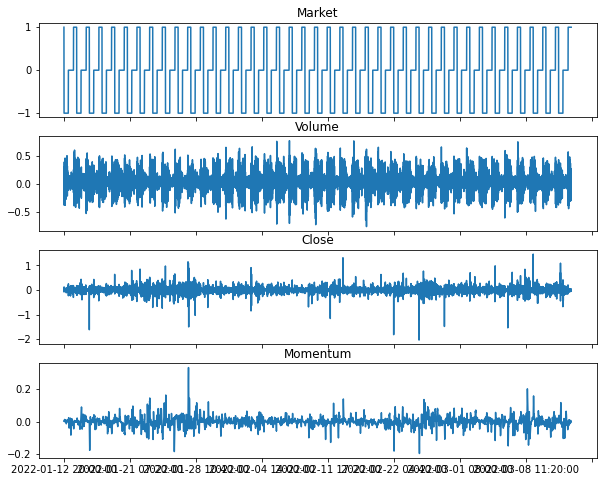

In [530]:
size = globalpar['test1']['structure']['total_size']
fig, ax = plt.subplots(4, 1, sharex='col', sharey='row', figsize=(10, 8))
apple_mom_Xmin[-size:]['market'].plot(figsize=(10,8), ax=ax[0], title='Market')
apple_mom_Xmin[-size:]['volume'].plot(figsize=(10,8), ax=ax[1], title='Volume')
apple_mom_Xmin[-size:]['close'].plot(figsize=(10,8), ax=ax[2], title='Close')
apple_mom_Xmin[-size:]['momentum'].plot(figsize=(10,8), ax=ax[3], title='Momentum')

In [531]:
checking_adf(apple_mom_Xmin, globalpar['test1']['structure']['total_size'], 20)

,ADF,p-value,n_lags,1%,5%,10%,stationary
market,-10.323305,0.0,20,-3.43052,-2.861615,-2.56681,True
close,-42.51606,0.0,20,-3.43052,-2.861615,-2.56681,True
volume,-67.71302,0.0,20,-3.43052,-2.861615,-2.56681,True
momentum,-24.215817,0.0,20,-3.43052,-2.861615,-2.56681,True
next,-42.516056,0.0,20,-3.43052,-2.861615,-2.56681,True


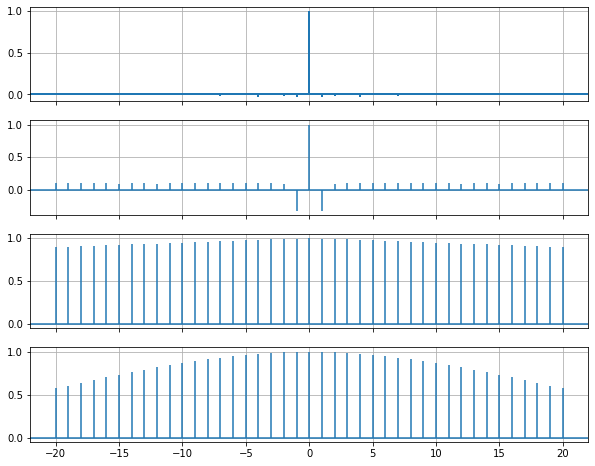

In [532]:
size = globalpar['test1']['structure']['total_size']
fig, ax = plt.subplots(4, 1, sharex='col', sharey='row', figsize=(10, 8))
ax[0].acorr(apple_mom_Xmin[-size:]['close'], usevlines=True, normed=True, maxlags=20, lw=2)
ax[0].grid(True)
ax[1].acorr(apple_mom_Xmin[-size:]['volume'], maxlags = 20)
ax[1].grid(True)
ax[2].acorr(apple_mom_Xmin[-size:]['market'], maxlags = 20)
ax[2].grid(True)
ax[3].acorr(apple_mom_Xmin[-size:]['momentum'], maxlags = 20)
ax[3].grid(True)

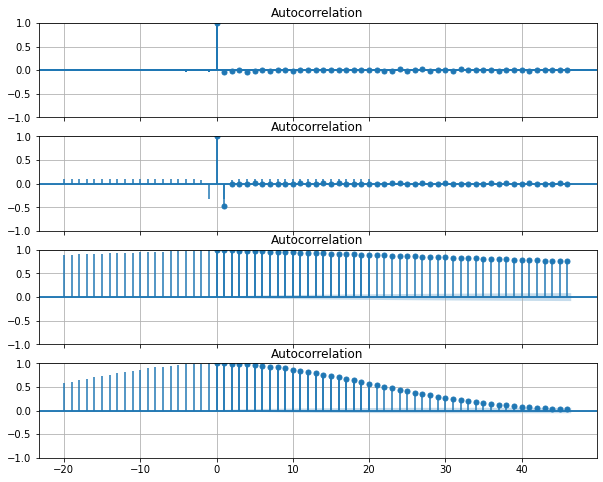

In [533]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
#fig, ax = plt.subplots(4, 1, sharex='col', sharey='row', figsize=(10, 8))
plot_acf(apple_mom_Xmin[-size:]['close'], ax=ax[0])
plot_acf(apple_mom_Xmin[-size:]['volume'], ax=ax[1])
plot_acf(apple_mom_Xmin[-size:]['market'], ax=ax[2])
plot_acf(apple_mom_Xmin[-size:]['momentum'], ax=ax[3])

In [534]:
train_X, train_y, test_X, test_y = final_array(apple_mom_Xmin, globalpar['test1']['structure'])

#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, train_X)

dataset len: 38420
total_batches: 600
total_test_batches: 120
total_train_batches: 480
-38419 -7680 -7699
train values shape: (30739, 5), test values shape: (7699, 5)
train X shape: (30739, 4), train y shape: (30720,)
train_batches: 30720
final train X shape: (30720, 20, 4), train y shape: (30720,)
test X shape: (7699, 4), test y shape: (7680,)
test_batches: 7680
final test X shape: (7680, 20, 4), test y shape: (7680,)


In [339]:
model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y,
                                              globalpar['test1']['training'])

Optimizer: Adam, Leaning rate: 0.003
Epoch[10/300] | loss train:0.00293378, test:0.00025210, learning rate: 0.003
Epoch[20/300] | loss train:0.00289034, test:0.00025548, learning rate: 0.003
Epoch[30/300] | loss train:0.00280467, test:0.00024987, learning rate: 0.003
Epoch[40/300] | loss train:0.00262913, test:0.00027058, learning rate: 0.003
Epoch[50/300] | loss train:0.00243860, test:0.00025282, learning rate: 0.003
Epoch[60/300] | loss train:0.00237247, test:0.00025567, learning rate: 0.003
Epoch[70/300] | loss train:0.00235275, test:0.00027204, learning rate: 0.003
Epoch[80/300] | loss train:0.00224657, test:0.00025167, learning rate: 0.003
Epoch[90/300] | loss train:0.00220097, test:0.00025251, learning rate: 0.003
Epoch[100/300] | loss train:0.00219075, test:0.00025556, learning rate: 0.003
Epoch[110/300] | loss train:0.00216612, test:0.00025538, learning rate: 0.003
Epoch[120/300] | loss train:0.00205948, test:0.00025689, learning rate: 0.003
Epoch[130/300] | loss train:0.002050

In [363]:
model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y,
                                              globalpar['test1']['training'])
### LAG to 12

Optimizer: Adam, Leaning rate: 0.003
Epoch[10/300] | loss train:0.00287915, test:0.00025503, learning rate: 0.003
Epoch[20/300] | loss train:0.00287937, test:0.00024906, learning rate: 0.003
Epoch[30/300] | loss train:0.00288260, test:0.00024899, learning rate: 0.003
Epoch[40/300] | loss train:0.00262809, test:0.00025374, learning rate: 0.003
Epoch[50/300] | loss train:0.00242213, test:0.00025056, learning rate: 0.003
Epoch[60/300] | loss train:0.00241197, test:0.00024973, learning rate: 0.003
Epoch[70/300] | loss train:0.00238145, test:0.00025162, learning rate: 0.003
Epoch[80/300] | loss train:0.00235054, test:0.00025937, learning rate: 0.003
Epoch[90/300] | loss train:0.00247220, test:0.00025375, learning rate: 0.003
Epoch[100/300] | loss train:0.00241186, test:0.00025519, learning rate: 0.003
Epoch[110/300] | loss train:0.00232929, test:0.00025230, learning rate: 0.003
Epoch[120/300] | loss train:0.00230025, test:0.00025908, learning rate: 0.003
Epoch[130/300] | loss train:0.002225

In [405]:
# hidden layers to 3, seq=20, sma=30,  dropout to 0.1, #4800
model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y,
                                              globalpar['test1']['training'])

Optimizer: Adam, Leaning rate: 0.003
Epoch[10/600] | loss train:0.00798216, test:0.00165594, learning rate: 0.003
Epoch[20/600] | loss train:0.00784177, test:0.00171891, learning rate: 0.003
Epoch[30/600] | loss train:0.00763121, test:0.00179277, learning rate: 0.003
Epoch[40/600] | loss train:0.00742356, test:0.00167541, learning rate: 0.003
Epoch[50/600] | loss train:0.00707429, test:0.00196714, learning rate: 0.003
Epoch[60/600] | loss train:0.00653216, test:0.00182272, learning rate: 0.003
Epoch[70/600] | loss train:0.00593887, test:0.00192555, learning rate: 0.003
Epoch[80/600] | loss train:0.00524752, test:0.00196716, learning rate: 0.003
Epoch[90/600] | loss train:0.00424021, test:0.00214721, learning rate: 0.003
Epoch[100/600] | loss train:0.00318199, test:0.00229311, learning rate: 0.003
Epoch[110/600] | loss train:0.00351092, test:0.00211317, learning rate: 0.003
Epoch[120/600] | loss train:0.00152954, test:0.00210343, learning rate: 0.003
Epoch[130/600] | loss train:0.000910

In [437]:
# hidden layers to 3, seq=20, sma=30,  dropout to 0.15, #9600
model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y,
                                              globalpar['test1']['training'])

Optimizer: Adam, Leaning rate: 0.001
Epoch[10/600] | loss train:0.01279449, test:0.00285416, learning rate: 0.001
Epoch[20/600] | loss train:0.01272884, test:0.00284371, learning rate: 0.001
Epoch[30/600] | loss train:0.01259341, test:0.00283831, learning rate: 0.001
Epoch[40/600] | loss train:0.01246806, test:0.00288875, learning rate: 0.001
Epoch[50/600] | loss train:0.01215737, test:0.00305430, learning rate: 0.001
Epoch[60/600] | loss train:0.01176773, test:0.00314881, learning rate: 0.001
Epoch[70/600] | loss train:0.01146047, test:0.00324484, learning rate: 0.001
Epoch[80/600] | loss train:0.01105901, test:0.00343645, learning rate: 0.001
Epoch[90/600] | loss train:0.01054093, test:0.00347667, learning rate: 0.001
Epoch[100/600] | loss train:0.00978560, test:0.00380212, learning rate: 0.001
Epoch[110/600] | loss train:0.00905329, test:0.00373304, learning rate: 0.001
Epoch[120/600] | loss train:0.00863975, test:0.00365373, learning rate: 0.001
Epoch[130/600] | loss train:0.008162

In [472]:
# hidden layers to 3, seq=20, sma=30,  dropout to 0.15, #19200
model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y,
                                              globalpar['test1']['training'])

Optimizer: Adam, Leaning rate: 0.001
Epoch[10/600] | loss train:0.02241989, test:0.00757904, learning rate: 0.001
Epoch[20/600] | loss train:0.02233788, test:0.00762477, learning rate: 0.001
Epoch[30/600] | loss train:0.02220594, test:0.00767154, learning rate: 0.001
Epoch[40/600] | loss train:0.02181844, test:0.00778058, learning rate: 0.001
Epoch[50/600] | loss train:0.02127105, test:0.00776920, learning rate: 0.001
Epoch[60/600] | loss train:0.02082275, test:0.00782894, learning rate: 0.001
Epoch[70/600] | loss train:0.02012927, test:0.00811354, learning rate: 0.001
Epoch[80/600] | loss train:0.01940594, test:0.00803279, learning rate: 0.001
Epoch[90/600] | loss train:0.01836894, test:0.00825999, learning rate: 0.001
Epoch[100/600] | loss train:0.01640170, test:0.00918714, learning rate: 0.001
Epoch[110/600] | loss train:0.01395322, test:0.00938281, learning rate: 0.001
Epoch[120/600] | loss train:0.01272735, test:0.00946191, learning rate: 0.001
Epoch[130/600] | loss train:0.011152

In [509]:
# hidden layers to 3, seq=20, sma=30,  dropout to 0.15, #19200, (Using -1,0,1 for market)
model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y,
                                              globalpar['test1']['training'])

Optimizer: Adam, Leaning rate: 0.001
Epoch[10/600] | loss train:0.02243556, test:0.00758016, learning rate: 0.001
Epoch[20/600] | loss train:0.02219665, test:0.00763648, learning rate: 0.001
Epoch[30/600] | loss train:0.02212886, test:0.00770881, learning rate: 0.001
Epoch[40/600] | loss train:0.02164200, test:0.00783373, learning rate: 0.001
Epoch[50/600] | loss train:0.02134677, test:0.00787723, learning rate: 0.001
Epoch[60/600] | loss train:0.02061428, test:0.00821218, learning rate: 0.001
Epoch[70/600] | loss train:0.02009678, test:0.00833390, learning rate: 0.001
Epoch[80/600] | loss train:0.01932218, test:0.00794134, learning rate: 0.001
Epoch[90/600] | loss train:0.01913978, test:0.00885987, learning rate: 0.001
Epoch[100/600] | loss train:0.01748433, test:0.00910651, learning rate: 0.001
Epoch[110/600] | loss train:0.01731631, test:0.00877308, learning rate: 0.001
Epoch[120/600] | loss train:0.01554910, test:0.00956819, learning rate: 0.001
Epoch[130/600] | loss train:0.013548

In [535]:
# hidden layers to 3, seq=20, sma=30,  dropout to 0.15, #38400
model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y,
                                              globalpar['test1']['training'])

Optimizer: Adam, Leaning rate: 0.001
Epoch[10/600] | loss train:0.04930234, test:0.01300207, learning rate: 0.001
Epoch[20/600] | loss train:0.04911062, test:0.01301477, learning rate: 0.001
Epoch[30/600] | loss train:0.04820456, test:0.01340480, learning rate: 0.001
Epoch[40/600] | loss train:0.04665929, test:0.01322756, learning rate: 0.001
Epoch[50/600] | loss train:0.04558925, test:0.01337664, learning rate: 0.001
Epoch[60/600] | loss train:0.04423726, test:0.01373559, learning rate: 0.001
Epoch[70/600] | loss train:0.04274205, test:0.01367502, learning rate: 0.001
Epoch[80/600] | loss train:0.04051634, test:0.01447773, learning rate: 0.001
Epoch[90/600] | loss train:0.03749038, test:0.01435353, learning rate: 0.001
Epoch[100/600] | loss train:0.03389741, test:0.01430861, learning rate: 0.001
Epoch[110/600] | loss train:0.03173754, test:0.01494119, learning rate: 0.001
Epoch[120/600] | loss train:0.02524982, test:0.01509817, learning rate: 0.001
Epoch[130/600] | loss train:0.023118

<AxesSubplot:title={'center':'Training Loss'}, xlabel='epochs', ylabel='Loss'>

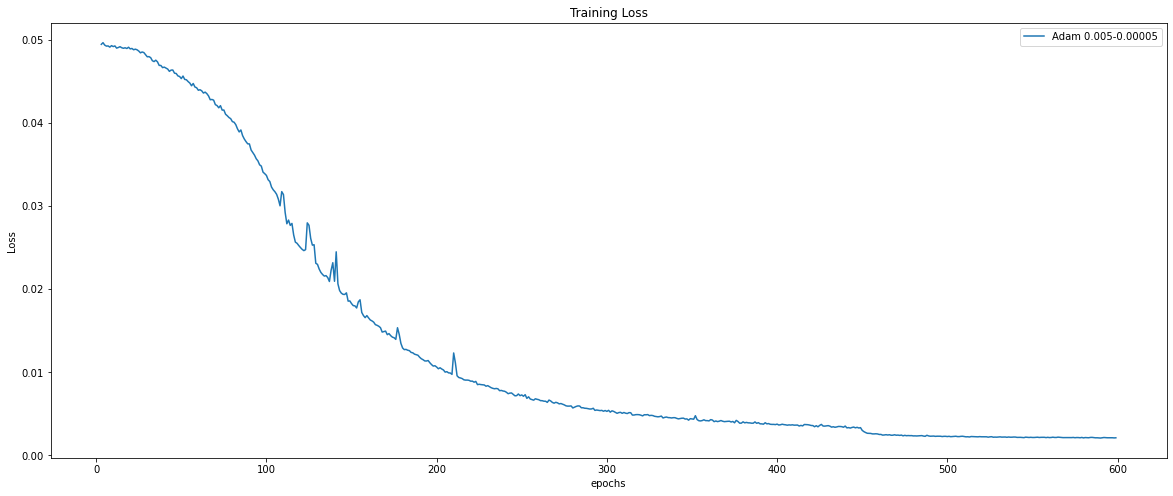

In [536]:
graphs_Adam_train = pd.DataFrame(loss_train, columns=['Adam 0.005-0.00005'])
graphs_Adam_train.loc[3:].plot(figsize=(20,8), title='Training Loss', xlabel='epochs', ylabel='Loss')

<AxesSubplot:title={'center':'Testing Loss'}, xlabel='epochs', ylabel='Loss'>

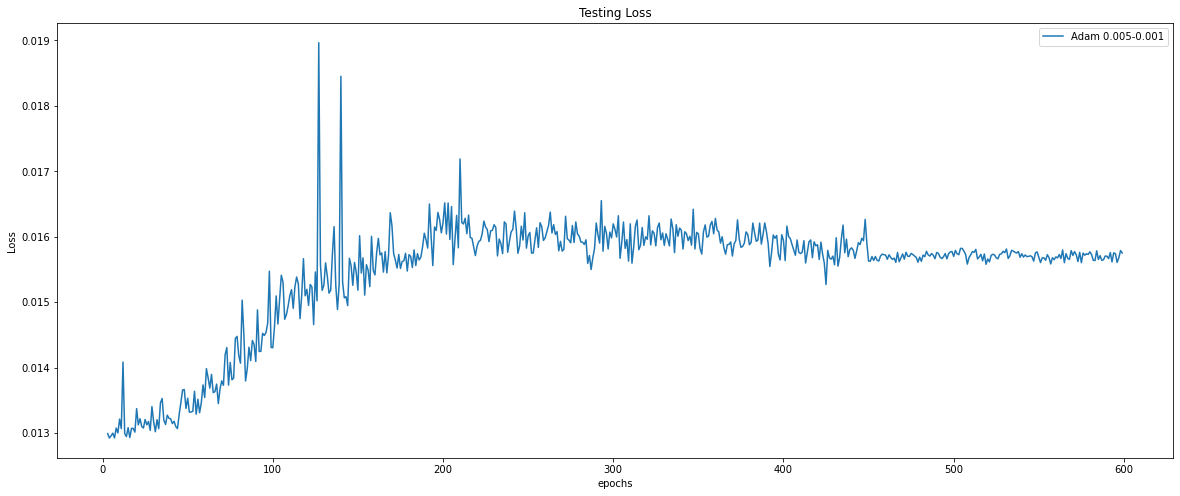

In [537]:
graphs_Adam_test = pd.DataFrame(loss_test, columns=['Adam 0.005-0.001'])
graphs_Adam_test.loc[3:].plot(figsize=(20,8), title='Testing Loss', xlabel='epochs', ylabel='Loss')

In [538]:
#x_to_predict, y_to_predict = data_to_predict(apple_mom_Xmin, globalpar['test1']['structure'])
#print(x_to_predict.shape, y_to_predict.shape)

In [539]:
size = globalpar['test1']['structure']['total_size']
ls = - int(globalpar['test1']['structure']['test_size'] * size / 2)
li = 6 * ls
long = int(globalpar['test1']['structure']['test_size'] * size / 4)


apple_mom_Xmin2 = pd.concat([apple_mom_Xmin.iloc[:ls], apple_mom_Xmin.iloc[li:(li+long)], apple_mom_Xmin.iloc[(ls+long):]])

In [540]:
print(ls, li, (li+long), (ls+long))

-3840 -23040 -21120 -1920


In [541]:
x_to_predict, y_to_predict = data_to_predict(apple_mom_Xmin2, globalpar['test1']['structure'])
print(x_to_predict.shape, y_to_predict.shape)

(38381, 20, 4) (38381,)


In [542]:
predicted_apple = predicted_df(model, x_to_predict, y_to_predict, globalpar['test1']['training'])
predicted_apple[-123:-58]

,close,close_predicted
38258,0.019397,-0.002088
38259,-0.012931,-0.018148
38260,-0.025867,-0.008348
38261,0.000000,-0.003609
38262,0.025867,-0.004180
...,...,...
38318,0.000000,0.005931
38319,-0.019421,0.007810
38320,0.000000,0.020552
38321,0.019421,-0.001263


<AxesSubplot:>

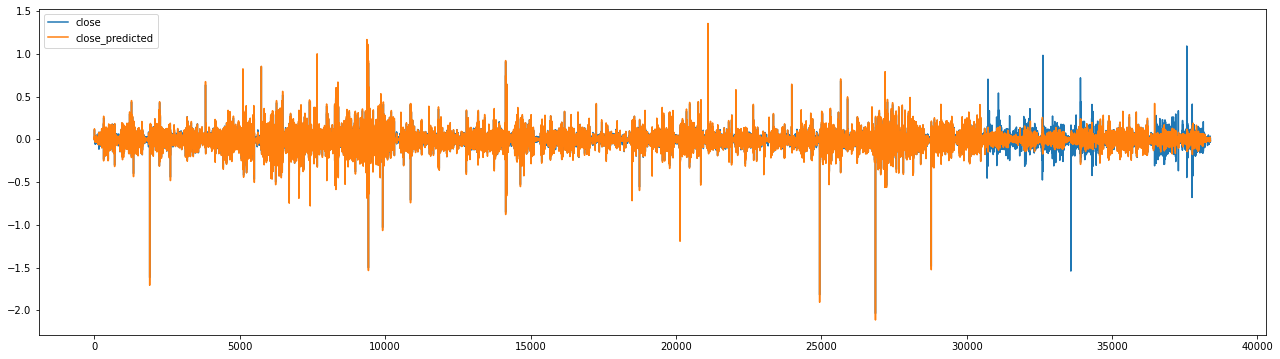

In [543]:
predicted_apple.plot(figsize=(22,6))

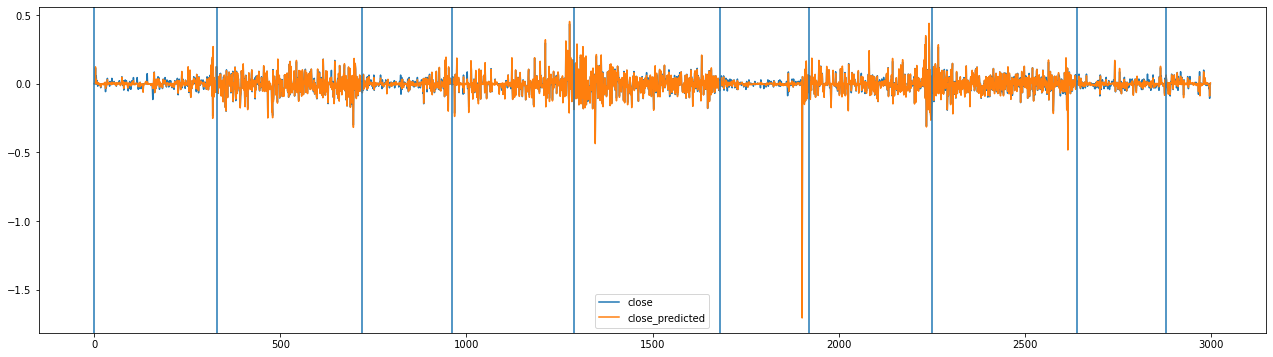

In [544]:
predicted_apple[:3000].plot(figsize=(22,6))
xcoords = [0, 330, 720, 960, 1290, 1680, 1920, 2250, 2640, 2880]
for xc in xcoords:
    plt.axvline(x=xc)

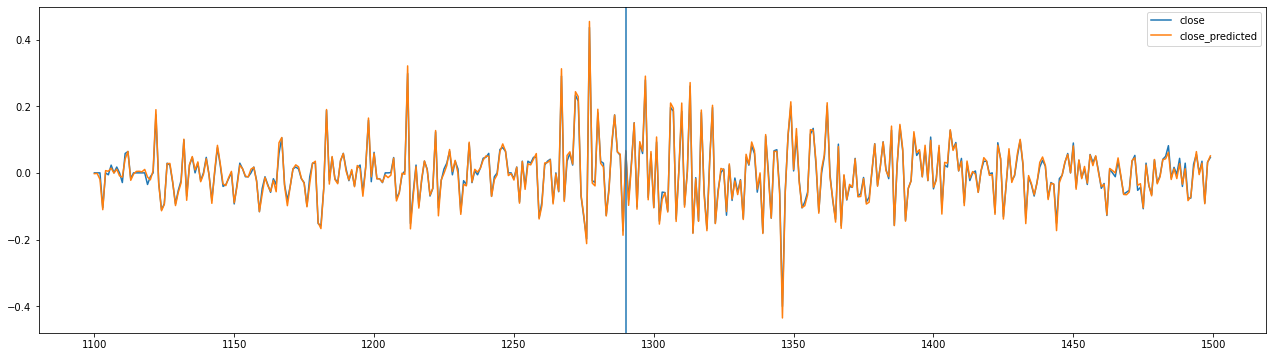

In [545]:
predicted_apple[1100:1500].plot(figsize=(22,6))
plt.axvline(x=1290)

<AxesSubplot:>

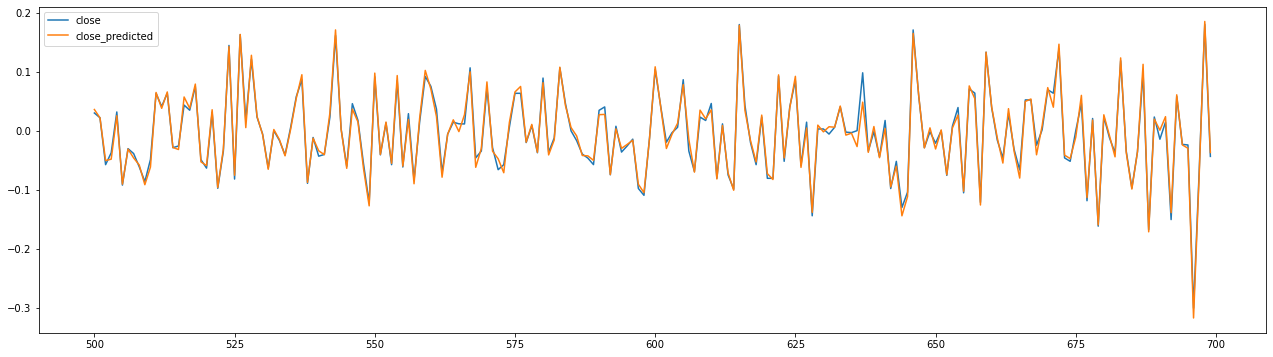

In [546]:
predicted_apple[500:700].plot(figsize=(22,6))
#plt.axvline(x=1680)

<AxesSubplot:>

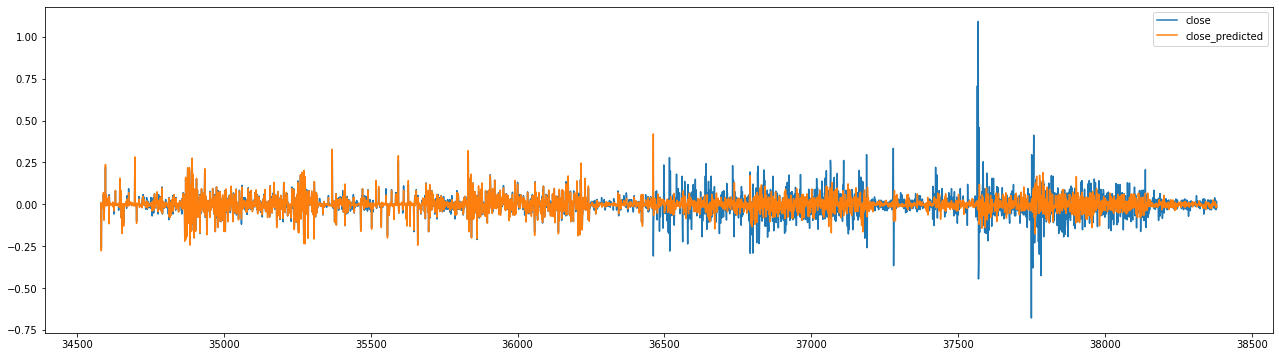

In [547]:
predicted_apple[-3800:].plot(figsize=(22,6))


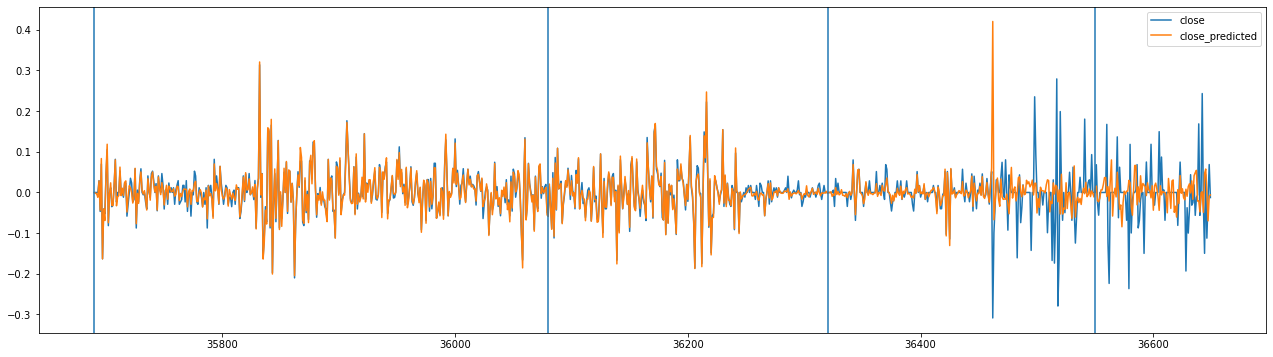

In [548]:
predicted_apple[35690:36650].plot(figsize=(22,6))
xcoords = [35690, 36080, 36320, 36550]
for xc in xcoords:
    plt.axvline(x=xc)

<AxesSubplot:>

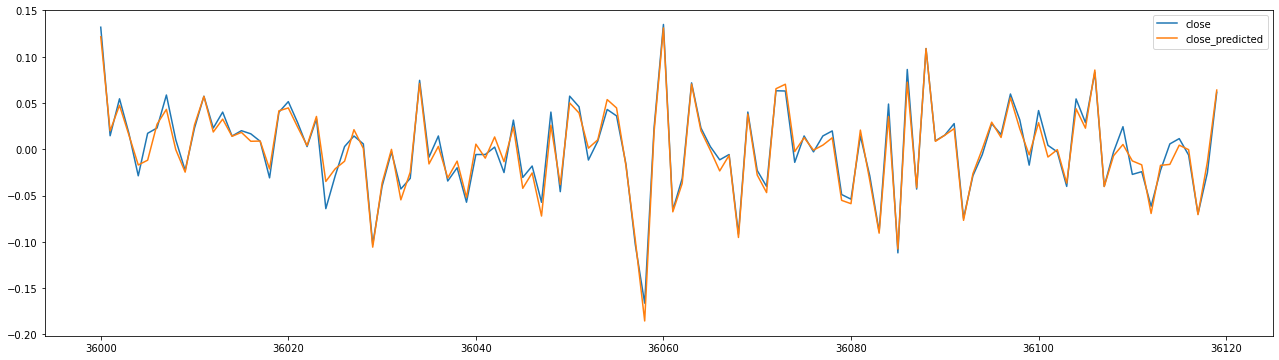

In [549]:
predicted_apple[36000:36120].plot(figsize=(22,6))

<AxesSubplot:>

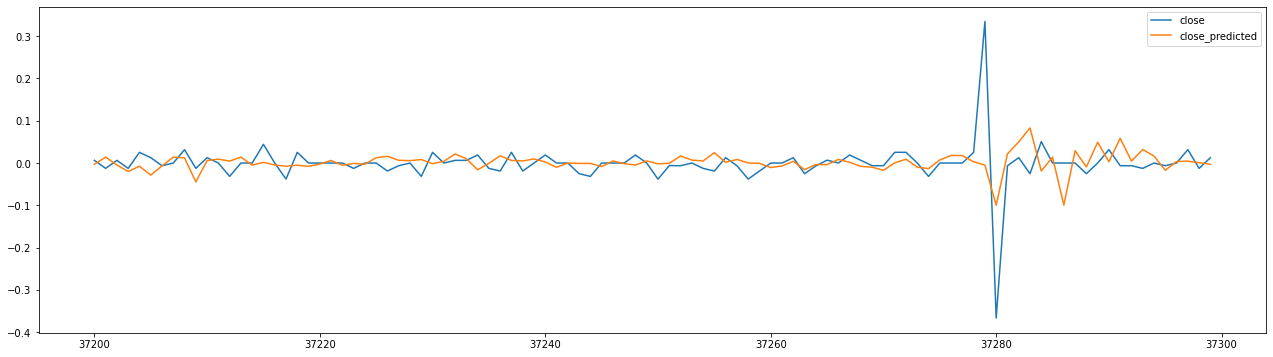

In [550]:
predicted_apple[37200:37300].plot(figsize=(22,6))

<AxesSubplot:>

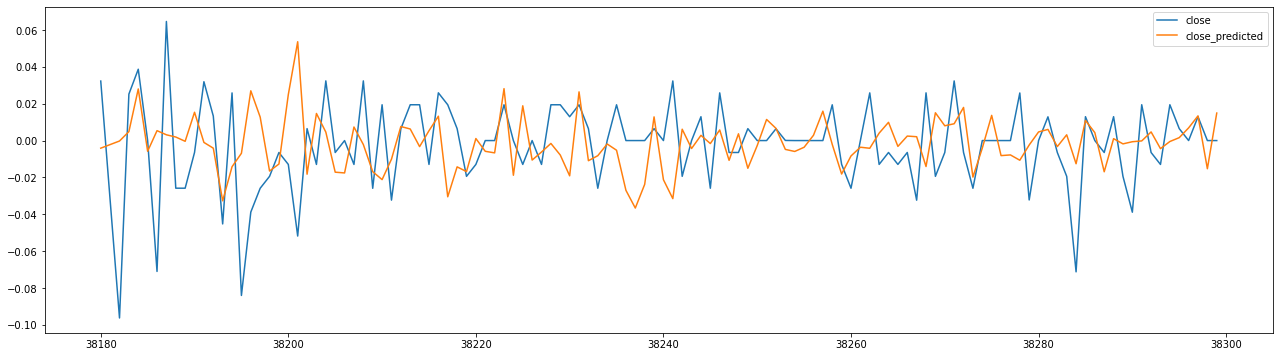

In [551]:
predicted_apple[38180:38300].plot(figsize=(22,6))